In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/multistage-malware-detection-and-classification-1/ember/train_features_4.jsonl
/kaggle/input/multistage-malware-detection-and-classification-1/ember/test_features.jsonl
/kaggle/input/multistage-malware-detection-and-classification-1/ember/train_features_1.jsonl
/kaggle/input/multistage-malware-detection-and-classification-1/ember/train_features_2.jsonl
/kaggle/input/multistage-malware-detection-and-classification-1/ember/train_features_3.jsonl
/kaggle/input/multistage-malware-detection-and-classification-1/ember/train_features_5.jsonl
/kaggle/input/multistage-malware-detection-and-classification-1/ember/ember_model_2017.txt
/kaggle/input/multistage-malware-detection-and-classification-1/ember/train_features_0.jsonl


In [3]:
# Chunk 1: Library Imports and Initial Setup

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc # For garbage collection
from tqdm.notebook import tqdm # For progress bars with iterators
import json # To read .jsonl files
import re # For regular expressions in .asm parsing
from collections import Counter
from sklearn.preprocessing import LabelEncoder, label_binarize
from itertools import cycle

# Set a consistent style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100 # Adjust figure resolution for better clarity

print("Libraries imported successfully.")
print("Initial setup complete.")

Libraries imported successfully.
Initial setup complete.


In [4]:
print("\n--- EMBER-2018 Dataset: Loading and Initial EDA (Revised) ---")

def load_ember_jsonl_revised(filepaths, process_limit=None):
    """
    Revised function to load EMBER features from .jsonl files based on the provided structure.
    It extracts features from 'histogram', 'byteentropy', 'strings', 'general', 'header', 'section', 'imports', 'exports'.
    """
    all_features_list = []
    ids_list = []
    labels_list = []
    family_ids_list = []
    
    # Keep track of all feature names collected to ensure consistency
    feature_names_set = set()

    print(f"Loading {len(filepaths)} EMBER .jsonl files...")
    num_processed = 0
    for fp in filepaths:
        print(f"Processing file: {os.path.basename(fp)}")
        with open(fp, 'r') as f:
            for line_num, line in enumerate(tqdm(f, desc=f"Reading {os.path.basename(fp)}")):
                if process_limit is not None and num_processed >= process_limit:
                    print(f"Reached processing limit of {process_limit} samples for EMBER. Stopping.")
                    break # Stop processing this file
                try:
                    entry = json.loads(line)
                    
                    current_sample_features = {}

                    # Basic metadata
                    ids_list.append(entry.get('sha256', entry.get('id')))
                    labels_list.append(entry.get('label', -1))
                    family_ids_list.append(entry.get('family_id', -1)) # family_id might not always be present

                    # --- Extract Numerical Features ---

                    # 1. From 'histogram'
                    histogram = entry.get('histogram', [])
                    for i, val in enumerate(histogram):
                        current_sample_features[f'hist_{i}'] = val
                    
                    # 2. From 'byteentropy'
                    byteentropy = entry.get('byteentropy', [])
                    for i, val in enumerate(byteentropy):
                        current_sample_features[f'byteentropy_{i}'] = val

                    # 3. From 'strings' (nested dictionary)
                    strings = entry.get('strings', {})
                    current_sample_features['str_numstrings'] = strings.get('numstrings', 0)
                    current_sample_features['str_avlength'] = strings.get('avlength', 0.0)
                    current_sample_features['str_printables'] = strings.get('printables', 0)
                    current_sample_features['str_entropy'] = strings.get('entropy', 0.0)
                    current_sample_features['str_paths'] = strings.get('paths', 0)
                    current_sample_features['str_urls'] = strings.get('urls', 0)
                    current_sample_features['str_registry'] = strings.get('registry', 0)
                    current_sample_features['str_MZ'] = strings.get('MZ', 0)
                    # Note: 'printabledist' is a list, can be added if needed, but increases dimensionality
                    # For now, let's omit it to keep feature count manageable.

                    # 4. From 'general'
                    general = entry.get('general', {})
                    current_sample_features['gen_size'] = general.get('size', 0)
                    current_sample_features['gen_vsize'] = general.get('vsize', 0)
                    current_sample_features['gen_has_debug'] = general.get('has_debug', 0)
                    current_sample_features['gen_exports'] = general.get('exports', 0)
                    current_sample_features['gen_imports_count'] = general.get('imports', 0) # Renamed to avoid clash with 'imports' dict
                    current_sample_features['gen_has_relocations'] = general.get('has_relocations', 0)
                    current_sample_features['gen_has_resources'] = general.get('has_resources', 0)
                    current_sample_features['gen_has_signature'] = general.get('has_signature', 0)
                    current_sample_features['gen_has_tls'] = general.get('has_tls', 0)
                    current_sample_features['gen_symbols'] = general.get('symbols', 0)

                    # 5. From 'header' -> 'coff' and 'optional'
                    header = entry.get('header', {})
                    coff = header.get('coff', {})
                    current_sample_features['hdr_coff_timestamp'] = coff.get('timestamp', 0)
                    # 'machine' and 'characteristics' are categorical, might need one-hot encoding if used directly.
                    # For simplicity, we might skip them or count specific characteristics for now.
                    # E.g., count total characteristics:
                    current_sample_features['hdr_coff_char_count'] = len(coff.get('characteristics', []))

                    optional = header.get('optional', {})
                    current_sample_features['hdr_opt_major_image_version'] = optional.get('major_image_version', 0)
                    current_sample_features['hdr_opt_minor_image_version'] = optional.get('minor_image_version', 0)
                    current_sample_features['hdr_opt_major_linker_version'] = optional.get('major_linker_version', 0)
                    current_sample_features['hdr_opt_minor_linker_version'] = optional.get('minor_linker_version', 0)
                    current_sample_features['hdr_opt_major_os_version'] = optional.get('major_operating_system_version', 0)
                    current_sample_features['hdr_opt_minor_os_version'] = optional.get('minor_operating_system_version', 0)
                    current_sample_features['hdr_opt_major_subsystem_version'] = optional.get('major_subsystem_version', 0)
                    current_sample_features['hdr_opt_minor_subsystem_version'] = optional.get('minor_subsystem_version', 0)
                    current_sample_features['hdr_opt_sizeof_code'] = optional.get('sizeof_code', 0)
                    current_sample_features['hdr_opt_sizeof_headers'] = optional.get('sizeof_headers', 0)
                    current_sample_features['hdr_opt_sizeof_heap_commit'] = optional.get('sizeof_heap_commit', 0)
                    # 'subsystem', 'dll_characteristics', 'magic' are categorical

                    # 6. From 'section'
                    section = entry.get('section', {})
                    sections_list = section.get('sections', [])
                    current_sample_features['sec_count'] = len(sections_list)
                    # Aggregate features from each section
                    total_sec_size = 0
                    total_sec_vsize = 0
                    total_sec_entropy = 0
                    executable_sections = 0
                    writable_sections = 0
                    for s in sections_list:
                        total_sec_size += s.get('size', 0)
                        total_sec_vsize += s.get('vsize', 0)
                        total_sec_entropy += s.get('entropy', 0.0)
                        props = s.get('props', [])
                        if 'MEM_EXECUTE' in props:
                            executable_sections += 1
                        if 'MEM_WRITE' in props:
                            writable_sections += 1
                    current_sample_features['sec_total_size'] = total_sec_size
                    current_sample_features['sec_total_vsize'] = total_sec_vsize
                    current_sample_features['sec_avg_entropy'] = total_sec_entropy / current_sample_features['sec_count'] if current_sample_features['sec_count'] > 0 else 0.0
                    current_sample_features['sec_executable_count'] = executable_sections
                    current_sample_features['sec_writable_count'] = writable_sections

                    # 7. From 'imports' and 'exports' (count unique DLLs/APIs)
                    imports = entry.get('imports', {})
                    current_sample_features['imp_dll_count'] = len(imports) # Number of unique DLLs imported
                    total_imported_funcs = 0
                    for dll, funcs in imports.items():
                        total_imported_funcs += len(funcs)
                    current_sample_features['imp_func_count'] = total_imported_funcs

                    exports = entry.get('exports', [])
                    current_sample_features['exp_count'] = len(exports) # Number of functions exported

                    # Add the extracted features for this sample to the list
                    all_features_list.append(current_sample_features)
                    num_processed += 1
                    
                except json.JSONDecodeError as e:
                    print(f"Skipping malformed JSON line {line_num+1} in {os.path.basename(fp)}: {e}")
                except Exception as e: # Catch any other unexpected errors during parsing
                    print(f"Skipping line {line_num+1} in {os.path.basename(fp)} due to unexpected error: {e}")
            if process_limit is not None and num_processed >= process_limit:
                break # Stop processing further files


--- EMBER-2018 Dataset: Loading and Initial EDA (Revised) ---


In [5]:
# load_ember_jsonl_revised Function Definition

def load_ember_jsonl_revised(filepaths, process_limit=None):
    """
    Revised function to load EMBER features from .jsonl files based on the provided structure.
    It extracts features from 'histogram', 'byteentropy', 'strings', 'general', 'header', 'section', 'imports', 'exports'.
    """
    all_features_list = [] # This list will hold dictionaries of features for each sample
    ids_list = []
    labels_list = []
    family_ids_list = []
    
    print(f"Loading {len(filepaths)} EMBER .jsonl files...")
    num_processed = 0
    for fp in filepaths:
        print(f"Processing file: {os.path.basename(fp)}")
        with open(fp, 'r') as f:
            for line_num, line in enumerate(tqdm(f, desc=f"Reading {os.path.basename(fp)}")):
                if process_limit is not None and num_processed >= process_limit:
                    print(f"Reached processing limit of {process_limit} samples for EMBER. Stopping.")
                    break # Stop processing this file and subsequent files
                try:
                    entry = json.loads(line)
                    
                    current_sample_features = {} # Dictionary to hold features for the current sample

                    # Basic metadata
                    ids_list.append(entry.get('sha256', entry.get('id')))
                    labels_list.append(entry.get('label', -1))
                    family_ids_list.append(entry.get('family_id', -1)) # family_id might not always be present

                    # --- Extract Numerical Features ---

                    # 1. From 'histogram' (list of 256 values)
                    histogram = entry.get('histogram', [])
                    for i, val in enumerate(histogram):
                        current_sample_features[f'hist_{i}'] = val
                    
                    # Ensure histogram has 256 features, fill with 0 if shorter
                    for i in range(len(histogram), 256):
                        current_sample_features[f'hist_{i}'] = 0

                    # 2. From 'byteentropy' (list of 256 values)
                    byteentropy = entry.get('byteentropy', [])
                    for i, val in enumerate(byteentropy):
                        current_sample_features[f'byteentropy_{i}'] = val
                    
                    # Ensure byteentropy has 256 features, fill with 0 if shorter
                    for i in range(len(byteentropy), 256):
                        current_sample_features[f'byteentropy_{i}'] = 0

                    # 3. From 'strings' (nested dictionary)
                    strings = entry.get('strings', {})
                    current_sample_features['str_numstrings'] = strings.get('numstrings', 0)
                    current_sample_features['str_avlength'] = strings.get('avlength', 0.0)
                    current_sample_features['str_printables'] = strings.get('printables', 0)
                    current_sample_features['str_entropy'] = strings.get('entropy', 0.0)
                    current_sample_features['str_paths'] = strings.get('paths', 0)
                    current_sample_features['str_urls'] = strings.get('urls', 0)
                    current_sample_features['str_registry'] = strings.get('registry', 0)
                    current_sample_features['str_MZ'] = strings.get('MZ', 0)
                    
                    printabledist = strings.get('printabledist', [])
                    if printabledist:
                        current_sample_features['str_printabledist_mean'] = np.mean(printabledist)
                        current_sample_features['str_printabledist_std'] = np.std(printabledist)
                    else:
                        current_sample_features['str_printabledist_mean'] = 0.0
                        current_sample_features['str_printabledist_std'] = 0.0


                    # 4. From 'general'
                    general = entry.get('general', {})
                    current_sample_features['gen_size'] = general.get('size', 0)
                    current_sample_features['gen_vsize'] = general.get('vsize', 0)
                    current_sample_features['gen_has_debug'] = general.get('has_debug', 0)
                    current_sample_features['gen_exports'] = general.get('exports', 0)
                    current_sample_features['gen_imports_count'] = general.get('imports', 0) # Renamed to avoid clash with 'imports' dict
                    current_sample_features['gen_has_relocations'] = general.get('has_relocations', 0)
                    current_sample_features['gen_has_resources'] = general.get('has_resources', 0)
                    current_sample_features['gen_has_signature'] = general.get('has_signature', 0)
                    current_sample_features['gen_has_tls'] = general.get('has_tls', 0)
                    current_sample_features['gen_symbols'] = general.get('symbols', 0)

                    # 5. From 'header' -> 'coff' and 'optional'
                    header = entry.get('header', {})
                    coff = header.get('coff', {})
                    current_sample_features['hdr_coff_timestamp'] = coff.get('timestamp', 0)
                    current_sample_features['hdr_coff_char_count'] = len(coff.get('characteristics', []))

                    optional = header.get('optional', {})
                    current_sample_features['hdr_opt_major_image_version'] = optional.get('major_image_version', 0)
                    current_sample_features['hdr_opt_minor_image_version'] = optional.get('minor_image_version', 0)
                    current_sample_features['hdr_opt_major_linker_version'] = optional.get('major_linker_version', 0)
                    current_sample_features['hdr_opt_minor_linker_version'] = optional.get('minor_linker_version', 0)
                    current_sample_features['hdr_opt_major_os_version'] = optional.get('major_operating_system_version', 0)
                    current_sample_features['hdr_opt_minor_os_version'] = optional.get('minor_operating_system_version', 0)
                    current_sample_features['hdr_opt_major_subsystem_version'] = optional.get('major_subsystem_version', 0)
                    current_sample_features['hdr_opt_minor_subsystem_version'] = optional.get('minor_subsystem_version', 0)
                    current_sample_features['hdr_opt_sizeof_code'] = optional.get('sizeof_code', 0)
                    current_sample_features['hdr_opt_sizeof_headers'] = optional.get('sizeof_headers', 0)
                    current_sample_features['hdr_opt_sizeof_heap_commit'] = optional.get('sizeof_heap_commit', 0)

                    # 6. From 'section'
                    section = entry.get('section', {})
                    sections_list = section.get('sections', [])
                    current_sample_features['sec_count'] = len(sections_list)
                    # Aggregate features from each section
                    total_sec_size = 0
                    total_sec_vsize = 0
                    total_sec_entropy = 0
                    executable_sections = 0
                    writable_sections = 0
                    for s in sections_list:
                        total_sec_size += s.get('size', 0)
                        total_sec_vsize += s.get('vsize', 0)
                        total_sec_entropy += s.get('entropy', 0.0)
                        props = s.get('props', [])
                        if 'MEM_EXECUTE' in props:
                            executable_sections += 1
                        if 'MEM_WRITE' in props:
                            writable_sections += 1
                    current_sample_features['sec_total_size'] = total_sec_size
                    current_sample_features['sec_total_vsize'] = total_sec_vsize
                    current_sample_features['sec_avg_entropy'] = total_sec_entropy / current_sample_features['sec_count'] if current_sample_features['sec_count'] > 0 else 0.0
                    current_sample_features['sec_executable_count'] = executable_sections
                    current_sample_features['sec_writable_count'] = writable_sections

                    # 7. From 'imports' and 'exports' (count unique DLLs/APIs)
                    imports = entry.get('imports', {})
                    current_sample_features['imp_dll_count'] = len(imports) # Number of unique DLLs imported
                    total_imported_funcs = 0
                    for dll, funcs in imports.items():
                        total_imported_funcs += len(funcs)
                    current_sample_features['imp_func_count'] = total_imported_funcs

                    exports = entry.get('exports', [])
                    current_sample_features['exp_count'] = len(exports) # Number of functions exported

                    # Add the extracted features for this sample to the list
                    all_features_list.append(current_sample_features)
                    num_processed += 1
                    
                except json.JSONDecodeError as e:
                    print(f"Skipping malformed JSON line {line_num+1} in {os.path.basename(fp)}: {e}")
                except Exception as e: # Catch any other unexpected errors during parsing
                    print(f"Skipping line {line_num+1} in {os.path.basename(fp)} due to unexpected error: {e}")
            if process_limit is not None and num_processed >= process_limit:
                break # Stop processing further files

    # Convert list of dictionaries to DataFrame, handling varying keys by filling missing with 0
    features_df = pd.DataFrame(all_features_list)
    features_df = features_df.fillna(0) # Fill NaN values with 0 where some features might be missing for a sample

    # Convert features to a NumPy array for LightGBM
    X_features = features_df.to_numpy(dtype=np.float32)
    
    # Create a DataFrame for metadata (ID, label, family_id)
    metadata_df = pd.DataFrame({
        'id': ids_list,
        'label': labels_list,
        'family_id': family_ids_list
    })
    
    return X_features, metadata_df, list(features_df.columns) # Return feature names too

print("`load_ember_jsonl_revised` function defined.")

`load_ember_jsonl_revised` function defined.



--- EMBER-2018 Dataset: Loading and Initial EDA ---
Loading 7 EMBER .jsonl files...
Processing file: train_features_0.jsonl


Reading train_features_0.jsonl: 0it [00:00, ?it/s]

Processing file: train_features_1.jsonl


Reading train_features_1.jsonl: 0it [00:00, ?it/s]

Reached processing limit of 100000 samples for EMBER. Stopping.

EMBER-2018 dataset loaded successfully with revised parser.
Total samples loaded: 100000
Features shape: (100000, 554)
Metadata head:
                                                  id  label  family_id
0  0abb4fda7d5b13801d63bee53e5e256be43e141faa077a...      0         -1
1  d4206650743b3d519106dea10a38a55c30467c3d9f7875...      0         -1
2  c9cafff8a596ba8a80bafb4ba8ae6f2ef3329d95b85f15...      0         -1
3  7f513818bcc276c531af2e641c597744da807e21cc1160...      0         -1
4  ca65e1c387a4cc9e7d8a8ce12bf1bcf9f534c9032b9d95...      0         -1
Number of extracted EMBER features: 554


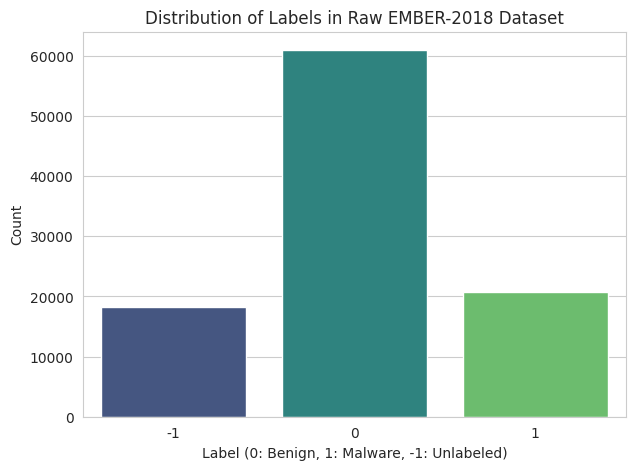

Samples before filtering unlabeled: 100000
Samples after removing unlabeled data: 81784


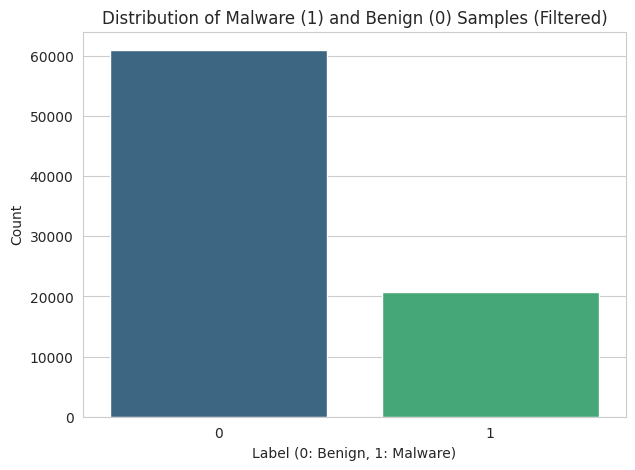

No NaN values found in EMBER features (as expected).

First 5 rows and first 10 columns of EMBER features (from revised parser):
    hist_0   hist_1   hist_2   hist_3   hist_4   hist_5   hist_6   hist_7  \
0  45521.0  13095.0  12167.0  12496.0  12429.0  11709.0  11864.0  12057.0   
1  89698.0  17443.0  13695.0  12921.0  11428.0   8866.0   9528.0   9548.0   
2  93059.0  15789.0   2871.0   3005.0   4107.0   1771.0   2918.0   4312.0   
3  21315.0   9641.0   9332.0   9358.0   9598.0   9220.0   9146.0   9382.0   
4  23539.0   6015.0   5214.0   4727.0   4892.0   4649.0   4367.0   5299.0   

    hist_8   hist_9  
0  12881.0  11798.0  
1  10282.0   6722.0  
2   4610.0    903.0  
3   9365.0   9116.0  
4   5625.0   4361.0  


In [6]:
# EMBER Data Loading and Initial EDA

print("\n--- EMBER-2018 Dataset: Loading and Initial EDA ---")

# Define the paths to your EMBER .jsonl files
ember_train_filepaths = [
    '/kaggle/input/multistage-malware-detection-and-classification-1/ember/train_features_0.jsonl',
    '/kaggle/input/multistage-malware-detection-and-classification-1/ember/train_features_1.jsonl',
    '/kaggle/input/multistage-malware-detection-and-classification-1/ember/train_features_2.jsonl',
    '/kaggle/input/multistage-malware-detection-and-classification-1/ember/train_features_3.jsonl',
    '/kaggle/input/multistage-malware-detection-and-classification-1/ember/train_features_4.jsonl',
    '/kaggle/input/multistage-malware-detection-and-classification-1/ember/train_features_5.jsonl'
]
ember_test_filepath = '/kaggle/input/multistage-malware-detection-and-classification-1/ember/test_features.jsonl'

# !!! IMPORTANT: Adjust this limit !!!
# Set a limit for processing samples. Start small (e.g., 10000) for testing.
# Set to None to load the full dataset once you confirm it works.
process_limit_ember = 100000 # For faster testing and to prevent crashes

try:
    X_full_ember, metadata_full_ember, ember_feature_names = load_ember_jsonl_revised(
        ember_train_filepaths + [ember_test_filepath],
        process_limit=process_limit_ember
    )
    print("\nEMBER-2018 dataset loaded successfully with revised parser.")
    print(f"Total samples loaded: {len(metadata_full_ember)}")
    print(f"Features shape: {X_full_ember.shape}")
    print(f"Metadata head:\n{metadata_full_ember.head()}")
    print(f"Number of extracted EMBER features: {len(ember_feature_names)}")

except Exception as e:
    print(f"Critical Error loading EMBER-2018 dataset: {e}. Please check the data format or path.")
    # If data loading fails critically, you might want to stop here to debug
    raise # Re-raise the exception to stop execution and show the error

# Distribution of labels
plt.figure(figsize=(7, 5))
sns.countplot(x='label', data=metadata_full_ember, palette='viridis')
plt.title('Distribution of Labels in Raw EMBER-2018 Dataset')
plt.xlabel('Label (0: Benign, 1: Malware, -1: Unlabeled)')
plt.ylabel('Count')
plt.show()

# Drop unlabeled samples for malware identification training
initial_samples = len(metadata_full_ember)
metadata_filtered_ember = metadata_full_ember[metadata_full_ember['label'] != -1].copy()
# Filter X_full_ember using the same boolean mask
X_filtered_ember = X_full_ember[metadata_full_ember['label'] != -1]

print(f"Samples before filtering unlabeled: {initial_samples}")
print(f"Samples after removing unlabeled data: {len(metadata_filtered_ember)}")

# Verify the distribution after filtering
plt.figure(figsize=(7, 5))
sns.countplot(x='label', data=metadata_filtered_ember, palette='viridis')
plt.title('Distribution of Malware (1) and Benign (0) Samples (Filtered)')
plt.xlabel('Label (0: Benign, 1: Malware)')
plt.ylabel('Count')
plt.show()

# Check for any NaN values in features
if np.isnan(X_filtered_ember).any():
    print("Warning: NaN values found in EMBER features. LightGBM can handle them, but consider imputation if they are significant.")
else:
    print("No NaN values found in EMBER features (as expected).")

# Display a small part of the feature array to understand structure (first 5 rows, first 10 columns)
print("\nFirst 5 rows and first 10 columns of EMBER features (from revised parser):")
print(pd.DataFrame(X_filtered_ember[:5, :10], columns=ember_feature_names[:10]))

In [7]:
# Chunk 4: EMBER Data Preparation for Model Training

print("\nPreparing data for EMBER-2018 Malware Identification model...")

X_ember_id = X_filtered_ember
y_ember_id = metadata_filtered_ember['label']

X_train_ember_id, X_test_ember_id, y_train_ember_id, y_test_ember_id = train_test_split(
    X_ember_id, y_ember_id, test_size=0.2, random_state=42, stratify=y_ember_id
)

print(f"X_train_ember_id shape: {X_train_ember_id.shape}")
print(f"X_test_ember_id shape: {X_test_ember_id.shape}")
print(f"y_train_ember_id shape: {y_train_ember_id.shape}")
print(f"y_test_ember_id shape: {y_test_ember_id.shape}")

# Clear full dataframes to save memory
del X_full_ember, metadata_full_ember, X_filtered_ember, metadata_filtered_ember, X_ember_id, y_ember_id
gc.collect()
print("Memory cleaned after data preparation.")


Preparing data for EMBER-2018 Malware Identification model...
X_train_ember_id shape: (65427, 554)
X_test_ember_id shape: (16357, 554)
y_train_ember_id shape: (65427,)
y_test_ember_id shape: (16357,)
Memory cleaned after data preparation.


In [8]:
import pandas as pd
import numpy as np
import gc
import os
from tqdm.notebook import tqdm
import json # Ensure json is imported if not already globally accessible

# Assuming load_ember_jsonl_revised function is defined from Chunk 1/2.
# If you don't have this function defined in your current kernel,
# you will need to re-run the cell where 'load_ember_jsonl_revised' is defined.

print("\n--- Loading Dedicated EMBER Test Dataset (200k samples) ---")

ember_test_filepath = '/kaggle/input/multistage-malware-detection-and-classification-1/ember/test_features.jsonl'

try:
    # Load the test data specifically, without any process limit, for the final evaluation
    # This will create the X_test_filtered and y_true_test variables your prediction code expects.
    X_test_raw_dedicated, metadata_test_raw_dedicated, _ = load_ember_jsonl_revised(
        [ember_test_filepath], # Pass as a list, even for a single file
        process_limit=None # Load ALL samples from the dedicated test file (200k)
    )
    print(f"Raw Dedicated Test data loaded. Shape: {X_test_raw_dedicated.shape}, Metadata: {len(metadata_test_raw_dedicated)}")

    # Filter out unlabeled samples if any (EMBER test set should be fully labeled, but good practice)
    metadata_test_filtered_dedicated = metadata_test_raw_dedicated[metadata_test_raw_dedicated['label'] != -1].copy()
    X_test_filtered = X_test_raw_dedicated[metadata_test_raw_dedicated['label'] != -1]
    y_true_test = metadata_test_filtered_dedicated['label']

    print(f"Samples after unlabeled filtering in dedicated test set: {len(metadata_test_filtered_dedicated)}")
    print(f"Shape of X_test_filtered (dedicated test set): {X_test_filtered.shape}")
    print(f"Shape of y_true_test (dedicated test set): {y_true_test.shape}")

    # Aggressively clear the raw test data after creating the filtered versions
    del X_test_raw_dedicated
    del metadata_test_raw_dedicated
    del metadata_test_filtered_dedicated
    gc.collect()
    print("Memory for raw dedicated test data cleared.")

except Exception as e:
    print(f"Error loading dedicated test data: {e}")
    print("The kernel likely restarted during this step due to memory limitations, or the file path is incorrect.")
    # Consider reducing the test set size or preprocessing it to .npy/.parquet if this repeatedly fails.


--- Loading Dedicated EMBER Test Dataset (200k samples) ---
Loading 1 EMBER .jsonl files...
Processing file: test_features.jsonl


Reading test_features.jsonl: 0it [00:00, ?it/s]

Raw Dedicated Test data loaded. Shape: (200000, 554), Metadata: 200000
Samples after unlabeled filtering in dedicated test set: 200000
Shape of X_test_filtered (dedicated test set): (200000, 554)
Shape of y_true_test (dedicated test set): (200000,)
Memory for raw dedicated test data cleared.


In [9]:
# Confirmation after loading dedicated test set
print(f"Is X_test_filtered defined? {'X_test_filtered' in locals()}")
if 'X_test_filtered' in locals():
    print(f"Shape of X_test_filtered (dedicated test set): {X_test_filtered.shape}")
    print(f"Shape of y_true_test (dedicated test set): {y_true_test.shape}")
else:
    print("X_test_filtered is still not defined. This indicates a memory issue or an error during the loading of the 200k test set.")

import gc
gc.collect() # Final memory clear before model prediction

Is X_test_filtered defined? True
Shape of X_test_filtered (dedicated test set): (200000, 554)
Shape of y_true_test (dedicated test set): (200000,)


0

In [10]:
# Part of Chunk 4, or a new mini-chunk after it, before Chunk 5

# Calculate class counts for the training set
benign_count = (y_train_ember_id == 0).sum()
malware_count = (y_train_ember_id == 1).sum()

# Calculate scale_pos_weight
# Avoid division by zero if for some reason malware_count is 0 (unlikely with sufficient data)
if malware_count > 0:
    scale_pos_weight_value = benign_count / malware_count
else:
    scale_pos_weight_value = 1 # Or handle as an error if no malware in training set
    print("Warning: No malware samples in training set. scale_pos_weight set to 1.")

print(f"\nTraining set class distribution: Benign={benign_count}, Malware={malware_count}")
print(f"Calculated scale_pos_weight: {scale_pos_weight_value:.2f}")


Training set class distribution: Benign=48793, Malware=16634
Calculated scale_pos_weight: 2.93


In [11]:
# Chunk 5: LightGBM Model Training (EMBER Identification)

print("\nTraining LightGBM model for malware identification...")

lgb_train_id = lgb.Dataset(X_train_ember_id, y_train_ember_id)
lgb_eval_id = lgb.Dataset(X_test_ember_id, y_test_ember_id, reference=lgb_train_id)

params_id = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42,
    'zero_as_missing': True,
    'scale_pos_weight': scale_pos_weight_value # <-- ADD THIS LINE
}

# Train the model with early stopping
model_ember_id = lgb.train(
    params_id,
    lgb_train_id,
    num_boost_round=1000,             # Max number of boosting rounds
    valid_sets=lgb_eval_id,
    callbacks=[lgb.early_stopping(100, verbose=False)], # Stop if no improvement for 100 rounds
)

print("\nLightGBM model training for malware identification complete.")
print(f"Best iteration: {model_ember_id.best_iteration}")



Training LightGBM model for malware identification...

LightGBM model training for malware identification complete.
Best iteration: 995


In [12]:
lgb_probs = model_ember_id.predict(X_test_ember_id, num_iteration=model_ember_id.best_iteration)



Evaluating EMBER-2018 Malware Identification model...
ROC AUC Score (EMBER-2018 Malware ID): 0.9988

Classification Report (EMBER-2018 Malware ID):
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99     12198
     Malware       0.98      0.98      0.98      4159

    accuracy                           0.99     16357
   macro avg       0.98      0.98      0.98     16357
weighted avg       0.99      0.99      0.99     16357



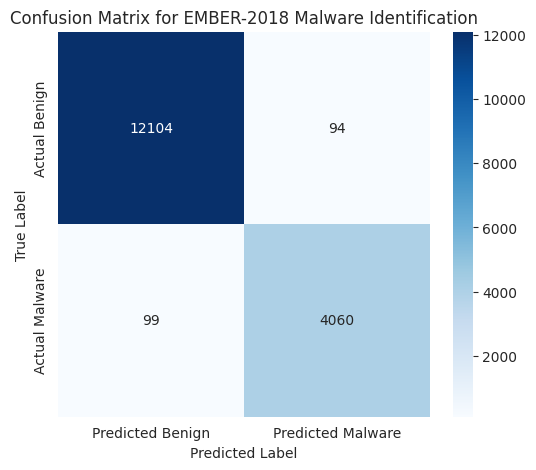

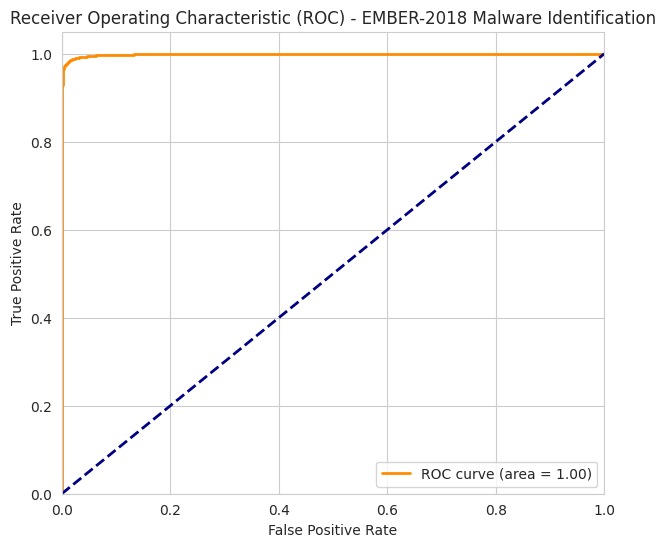


Feature Importance (Top 20) for EMBER-2018 Malware Identification model:


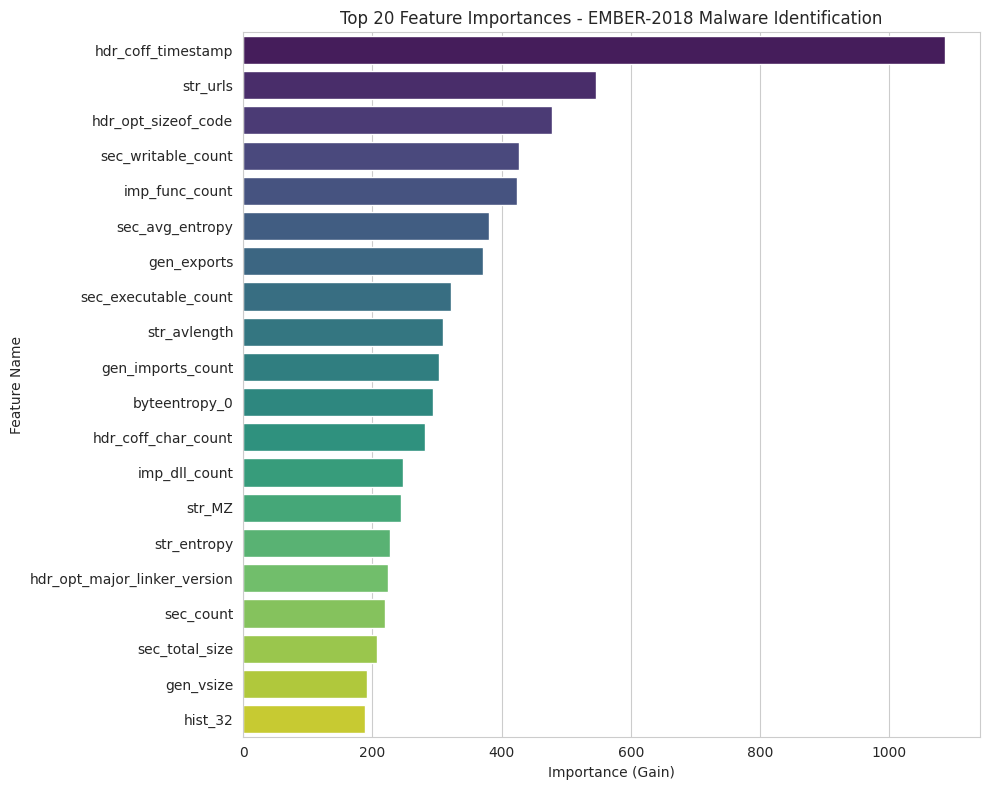

In [13]:
# Chunk 6: LightGBM Model Evaluation and Feature Importance (UPDATED)

print("\nEvaluating EMBER-2018 Malware Identification model...")

# Predict probabilities and classes
y_pred_proba_ember_id = model_ember_id.predict(X_test_ember_id, num_iteration=model_ember_id.best_iteration)
y_pred_ember_id = (y_pred_proba_ember_id > 0.5).astype(int) # Convert probabilities to binary predictions

# ROC AUC Score
roc_auc = roc_auc_score(y_test_ember_id, y_pred_proba_ember_id)
print(f"ROC AUC Score (EMBER-2018 Malware ID): {roc_auc:.4f}")

# Classification Report
print("\nClassification Report (EMBER-2018 Malware ID):")
print(classification_report(y_test_ember_id, y_pred_ember_id, target_names=['Benign', 'Malware'], zero_division=0))

# Confusion Matrix
cm_id = confusion_matrix(y_test_ember_id, y_pred_ember_id)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_id, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Benign', 'Predicted Malware'],
            yticklabels=['Actual Benign', 'Actual Malware'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for EMBER-2018 Malware Identification')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_ember_id, y_pred_proba_ember_id)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - EMBER-2018 Malware Identification')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Feature Importance
print("\nFeature Importance (Top 20) for EMBER-2018 Malware Identification model:")
feature_importances_id = pd.DataFrame({
    'feature': ember_feature_names,
    'importance': model_ember_id.feature_importance()
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_id.head(20), palette='viridis')
plt.title('Top 20 Feature Importances - EMBER-2018 Malware Identification')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

# Clean up EMBER data to free up memory for the next part
# IMPORTANT: Removed 'model_ember_id' from the deletion list
# del X_train_ember_id, X_test_ember_id, y_train_ember_id, y_test_ember_id, lgb_train_id, lgb_eval_id, feature_importances_id
# gc.collect()
# print("Memory cleaned after EMBER-2018 model evaluation (keeping model_ember_id).")



--- Testing the model on the dedicated EMBER Test Dataset ---
Loading 1 EMBER .jsonl files...
Processing file: test_features.jsonl


Reading test_features.jsonl: 0it [00:00, ?it/s]


Dedicated EMBER test dataset loaded successfully.
Total test samples loaded: 200000
Test features shape: (200000, 554)
Test samples before filtering unlabeled: 200000
Test samples after removing unlabeled data: 200000
X_test_filtered shape for prediction: (200000, 554)

Making predictions on the dedicated test dataset...

--- Final Model Evaluation on Dedicated Test Set ---
ROC AUC Score (Dedicated Test Set): 0.9933

Classification Report (Dedicated Test Set):
              precision    recall  f1-score   support

      Benign       0.92      0.98      0.95    100000
     Malware       0.98      0.92      0.95    100000

    accuracy                           0.95    200000
   macro avg       0.95      0.95      0.95    200000
weighted avg       0.95      0.95      0.95    200000



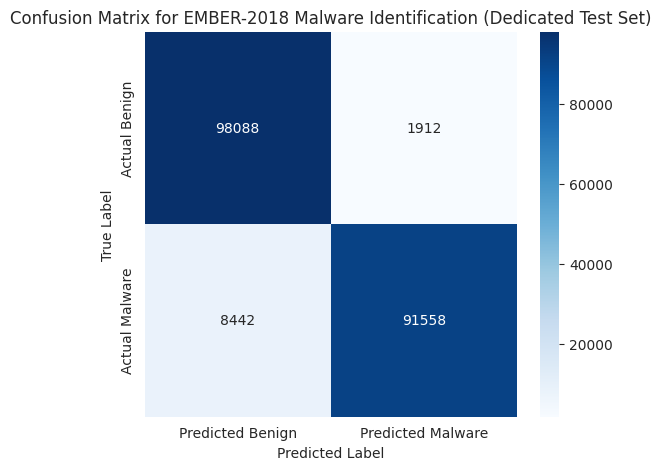

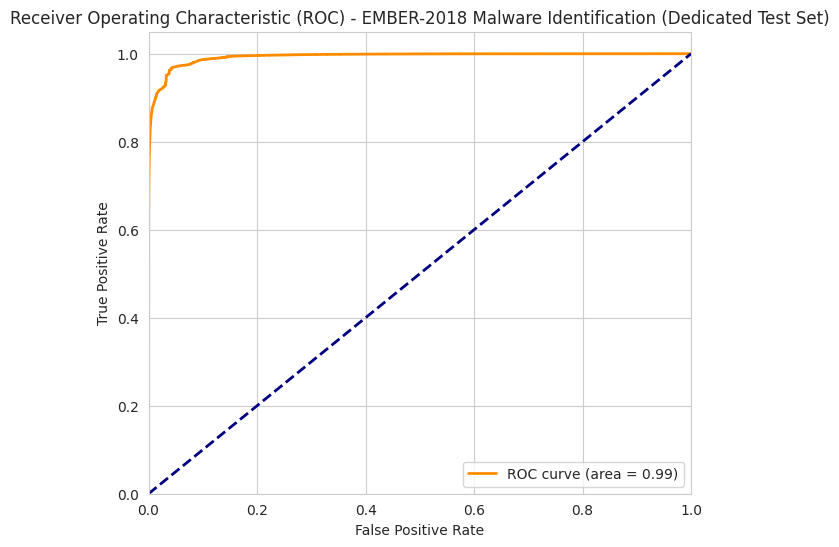

In [14]:
# Chunk 7: Load and Evaluate on the Dedicated Test Dataset (UPDATED)

print("\n--- Testing the model on the dedicated EMBER Test Dataset ---")

# Define the path to the test features file
ember_test_filepath_only = [
    '/kaggle/input/multistage-malware-detection-and-classification-1/ember/test_features.jsonl'
]

# Load ONLY the test dataset. Set process_limit to None to load all test samples.
try:
    # We don't need the feature names from the test load, so we use _ for the third return value
    X_test_ember_full, metadata_test_ember_full, _ = load_ember_jsonl_revised(
        ember_test_filepath_only,
        process_limit=None # Load all samples from the test file
    )
    print("\nDedicated EMBER test dataset loaded successfully.")
    print(f"Total test samples loaded: {len(metadata_test_ember_full)}")
    print(f"Test features shape: {X_test_ember_full.shape}")

except Exception as e:
    print(f"Critical Error loading dedicated EMBER test dataset: {e}. Cannot proceed with final testing.")
    raise # Re-raise the exception to stop execution if test data loading fails

# Filter out unlabeled samples (-1) from the test set, if any
initial_test_samples = len(metadata_test_ember_full)
metadata_test_filtered = metadata_test_ember_full[metadata_test_ember_full['label'] != -1].copy()
X_test_filtered = X_test_ember_full[metadata_test_ember_full['label'] != -1]

y_true_test = metadata_test_filtered['label']

print(f"Test samples before filtering unlabeled: {initial_test_samples}")
print(f"Test samples after removing unlabeled data: {len(metadata_test_filtered)}")
print(f"X_test_filtered shape for prediction: {X_test_filtered.shape}")

# Ensure the columns/features match between training and test (Crucial!)
# We use len(ember_feature_names) which was retained from Chunk 3's loading
# to check consistency with the features the model was trained on.
trained_feature_count = len(ember_feature_names) # Use the length of feature names from training
if X_test_filtered.shape[1] != trained_feature_count:
    print(f"WARNING: Feature count mismatch between training ({trained_feature_count}) and test ({X_test_filtered.shape[1]}).")
    print("This might happen if your initial `process_limit_ember` for training was too small and missed some features that appear in the test set.")
    print("Consider re-running Chunk 3 with `process_limit_ember = None` to load all possible features from the entire dataset for consistency, then retrain (Chunks 4-6).")
    # For now, we proceed, but this is a serious warning for model integrity.

# Make predictions on the dedicated test dataset
print("\nMaking predictions on the dedicated test dataset...")
# Ensure model_ember_id is available (it should be if you ran Chunk 5 and the updated Chunk 6)
y_pred_proba_final_test = model_ember_id.predict(X_test_filtered, num_iteration=model_ember_id.best_iteration)
y_pred_final_test = (y_pred_proba_final_test > 0.5).astype(int)

# Evaluate the model on the dedicated test dataset
print("\n--- Final Model Evaluation on Dedicated Test Set ---")

# ROC AUC Score
roc_auc_final = roc_auc_score(y_true_test, y_pred_proba_final_test)
print(f"ROC AUC Score (Dedicated Test Set): {roc_auc_final:.4f}")

# Classification Report
print("\nClassification Report (Dedicated Test Set):")
print(classification_report(y_true_test, y_pred_final_test, target_names=['Benign', 'Malware'], zero_division=0))

# Confusion Matrix
cm_final = confusion_matrix(y_true_test, y_pred_final_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Benign', 'Predicted Malware'],
            yticklabels=['Actual Benign', 'Actual Malware'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for EMBER-2018 Malware Identification (Dedicated Test Set)')
plt.show()

# ROC Curve
fpr_final, tpr_final, thresholds_final = roc_curve(y_true_test, y_pred_proba_final_test)
plt.figure(figsize=(7, 6))
plt.plot(fpr_final, tpr_final, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_final:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - EMBER-2018 Malware Identification (Dedicated Test Set)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Clean up memory
# del X_test_ember_full, metadata_test_ember_full, X_test_filtered, metadata_test_filtered, y_true_test
# del y_pred_proba_final_test, y_pred_final_test, cm_final, fpr_final, tpr_final, thresholds_final
# If you are done with the model entirely, you can uncomment the line below:
# del model_ember_id
# gc.collect()
# print("Memory cleaned after dedicated test set evaluation.")

In [15]:
import numpy as np
import pandas as pd
import gc # For garbage collection

# --- Part A: (Run this ONCE to preprocess and save) ---
# Assuming load_ember_jsonl_revised function is defined and paths are correct

print("--- Loading full EMBER training data (this may take a long time) ---")
ember_train_filepaths = [
    '/kaggle/input/multistage-malware-detection-and-classification-1/ember/train_features_0.jsonl',
    '/kaggle/input/multistage-malware-detection-and-classification-1/ember/train_features_1.jsonl',
    '/kaggle/input/multistage-malware-detection-and-classification-1/ember/train_features_2.jsonl',
    '/kaggle/input/multistage-malware-detection-and-classification-1/ember/train_features_3.jsonl',
    '/kaggle/input/multistage-malware-detection-and-classification-1/ember/train_features_4.jsonl',
    '/kaggle/input/multistage-malware-detection-and-classification-1/ember/train_features_5.jsonl'
]

# Set process_limit to None to load ALL available training samples
try:
    X_full_ember, metadata_full_ember, ember_feature_names = load_ember_jsonl_revised(
        ember_train_filepaths,
        process_limit=100000
    )
    print("Full EMBER training data loaded successfully.")
    print(f"Total samples loaded (raw): {len(metadata_full_ember)}")
    print(f"Feature names count: {len(ember_feature_names)}")

    # Filter out unlabeled data (-1)
    initial_samples = len(metadata_full_ember)
    metadata_filtered_ember = metadata_full_ember[metadata_full_ember['label'] != -1].copy()
    X_filtered_ember = X_full_ember[metadata_full_ember['label'] != -1]

    print(f"Samples after removing unlabeled data: {len(metadata_filtered_ember)}")

    # --- Save the processed data ---
    output_dir = '/kaggle/working/' # Or any other writable directory

    np.save(f'{output_dir}X_ember_train_processed.npy', X_filtered_ember)
    metadata_filtered_ember.to_parquet(f'{output_dir}metadata_ember_train_processed.parquet', index=False)
    # You might also want to save feature names if not always consistent
    pd.Series(ember_feature_names).to_csv(f'{output_dir}ember_feature_names.csv', index=False, header=False)


    print(f"Processed training features saved to: {output_dir}X_ember_train_processed.npy")
    print(f"Processed training metadata saved to: {output_dir}metadata_ember_train_processed.parquet")
    print("--- Preprocessing and saving complete. ---")

    # Clean up memory after saving
    # del X_full_ember, metadata_full_ember, metadata_filtered_ember, X_filtered_ember
    # gc.collect()

except Exception as e:
    print(f"An error occurred during full data loading: {e}")
    # Handle error or raise


--- Loading full EMBER training data (this may take a long time) ---
Loading 6 EMBER .jsonl files...
Processing file: train_features_0.jsonl


Reading train_features_0.jsonl: 0it [00:00, ?it/s]

Processing file: train_features_1.jsonl


Reading train_features_1.jsonl: 0it [00:00, ?it/s]

Reached processing limit of 100000 samples for EMBER. Stopping.
Full EMBER training data loaded successfully.
Total samples loaded (raw): 100000
Feature names count: 554
Samples after removing unlabeled data: 81784
Processed training features saved to: /kaggle/working/X_ember_train_processed.npy
Processed training metadata saved to: /kaggle/working/metadata_ember_train_processed.parquet
--- Preprocessing and saving complete. ---


In [16]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_auc_score, classification_report

# Instantiate models (tune n_estimators as needed)
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=42)
et = ExtraTreesClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=42)

# Fit
rf.fit(X_train_ember_id, y_train_ember_id)
et.fit(X_train_ember_id, y_train_ember_id)

# Predict probabilities
rf_probs = rf.predict_proba(X_test_ember_id)[:,1]
et_probs = et.predict_proba(X_test_ember_id)[:,1]

# Predict classes for reports
rf_preds = rf.predict(X_test_ember_id)
et_preds = et.predict(X_test_ember_id)

# Evaluate
print("Random Forest ROC-AUC:", roc_auc_score(y_test_ember_id, rf_probs))
print(classification_report(y_test_ember_id, rf_preds))
print("Extra Trees ROC-AUC:", roc_auc_score(y_test_ember_id, et_probs))
print(classification_report(y_test_ember_id, et_preds))


Random Forest ROC-AUC: 0.9963332827533009
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     12198
           1       0.98      0.93      0.95      4159

    accuracy                           0.98     16357
   macro avg       0.98      0.96      0.97     16357
weighted avg       0.98      0.98      0.98     16357

Extra Trees ROC-AUC: 0.9960801657637361
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     12198
           1       0.97      0.93      0.95      4159

    accuracy                           0.98     16357
   macro avg       0.98      0.96      0.97     16357
weighted avg       0.98      0.98      0.98     16357




--- Testing Random Forest on the dedicated test dataset ---
ROC AUC Score (Dedicated Test Set): 0.9908

Classification Report (Dedicated Test Set) for Random Forest:
              precision    recall  f1-score   support

      Benign       0.86      0.99      0.92    100000
     Malware       0.99      0.84      0.91    100000

    accuracy                           0.92    200000
   macro avg       0.93      0.92      0.92    200000
weighted avg       0.93      0.92      0.92    200000



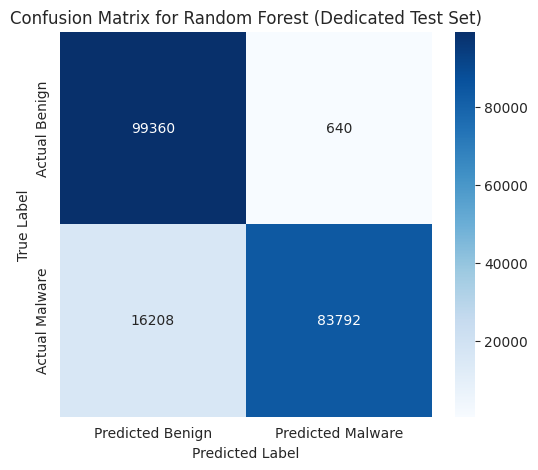

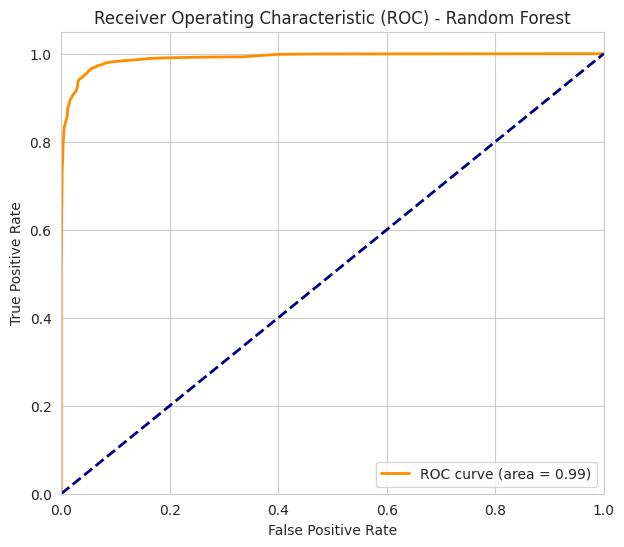


--- Testing Extra Trees on the dedicated test dataset ---
ROC AUC Score (Dedicated Test Set): 0.9898

Classification Report (Dedicated Test Set) for Extra Trees:
              precision    recall  f1-score   support

      Benign       0.84      0.99      0.91    100000
     Malware       0.99      0.80      0.89    100000

    accuracy                           0.90    200000
   macro avg       0.91      0.90      0.90    200000
weighted avg       0.91      0.90      0.90    200000



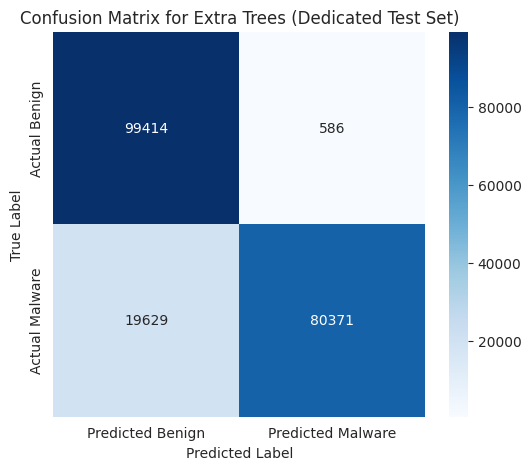

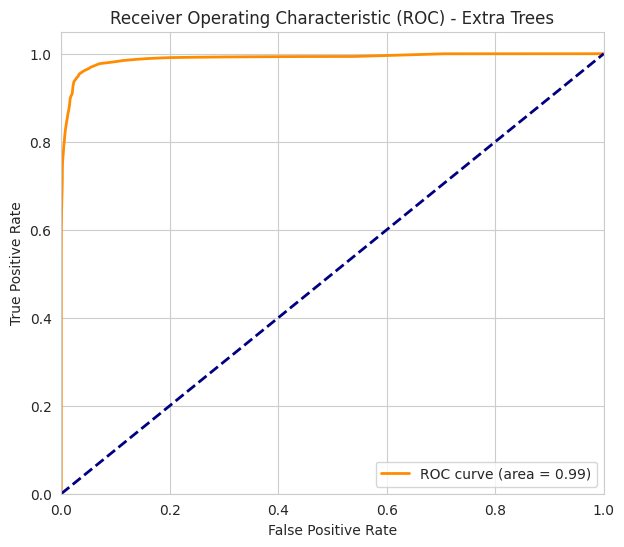

Memory cleaned after dedicated test set evaluation.


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, ConfusionMatrixDisplay
)
import gc

def evaluate_model_on_test_set(model, X_test, y_true, model_name="Model"):
    print(f"\n--- Testing {model_name} on the dedicated test dataset ---")

    # Predict probabilities and labels
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        # For models without predict_proba, fallback to predict
        y_pred_proba = model.predict(X_test).astype(float)
    y_pred = model.predict(X_test)

    # ROC AUC Score
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    print(f"ROC AUC Score (Dedicated Test Set): {roc_auc:.4f}")

    # Classification Report
    print(f"\nClassification Report (Dedicated Test Set) for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=["Benign", "Malware"], zero_division=0))

    # Confusion Matrix plot
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Benign', 'Predicted Malware'],
                yticklabels=['Actual Benign', 'Actual Malware'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name} (Dedicated Test Set)')
    plt.show()

    # ROC Curve plot
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Evaluate Random Forest on test set
evaluate_model_on_test_set(rf, X_test_filtered, y_true_test, model_name="Random Forest")

# Evaluate Extra Trees on test set
evaluate_model_on_test_set(et, X_test_filtered, y_true_test, model_name="Extra Trees")

# If you want, repeat this for other models such as:
# evaluate_model_on_test_set(clf, X_test_filtered, y_true_test, model_name="Your Model")

gc.collect()
print("Memory cleaned after dedicated test set evaluation.")


In [18]:
# For Random Forest
probs = rf.predict_proba(X_test_filtered)[:, 1]
preds = rf.predict(X_test_filtered)


ROC AUC: 0.9907847812000001
              precision    recall  f1-score   support

      Benign       0.86      0.99      0.92    100000
     Malware       0.99      0.84      0.91    100000

    accuracy                           0.92    200000
   macro avg       0.93      0.92      0.92    200000
weighted avg       0.93      0.92      0.92    200000



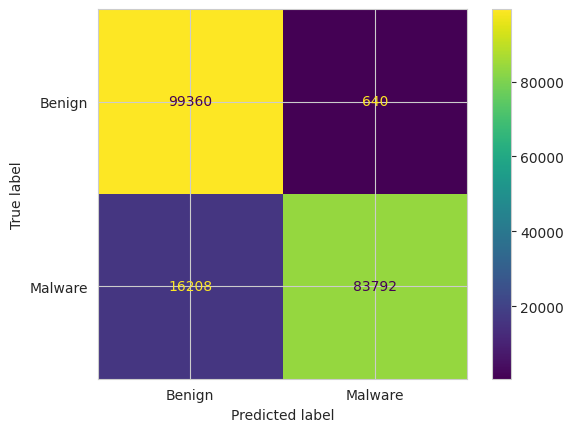

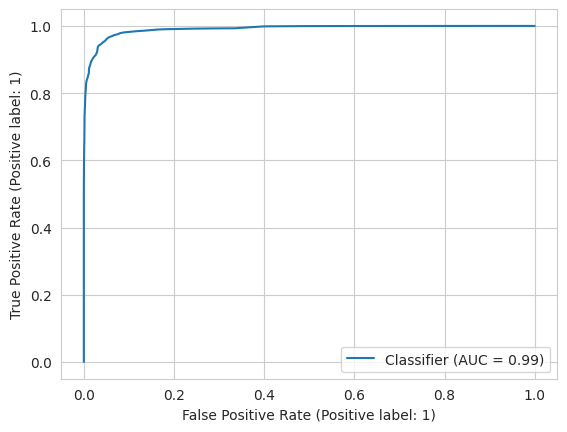

In [19]:
# Predict probabilities and classes
probs = rf.predict_proba(X_test_filtered)[:, 1]   # For scikit-learn models
# For LightGBM/XGBoost, you may need model.predict(X_test_filtered) for probabilities
preds = rf.predict(X_test_filtered)
if hasattr(preds, 'shape') and len(preds.shape) > 1:
    preds = np.argmax(preds, axis=1)

# Evaluation
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
print("ROC AUC:", roc_auc_score(y_true_test, probs))
print(classification_report(y_true_test, preds, target_names=["Benign", "Malware"]))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_true_test, preds, display_labels=['Benign', 'Malware'])
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_true_test, probs)
plt.show()


In [20]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=42)
et.fit(X_train_ember_id, y_train_ember_id)


ExtraTreesClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

Extra Trees ROC-AUC: 0.9960801657637361
              precision    recall  f1-score   support

      Benign       0.98      0.99      0.98     12198
     Malware       0.97      0.93      0.95      4159

    accuracy                           0.98     16357
   macro avg       0.98      0.96      0.97     16357
weighted avg       0.98      0.98      0.98     16357



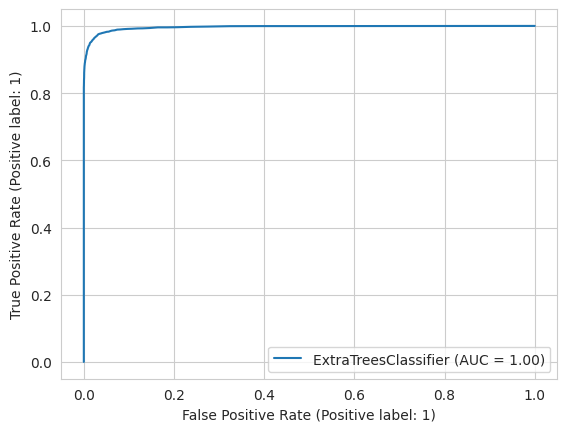

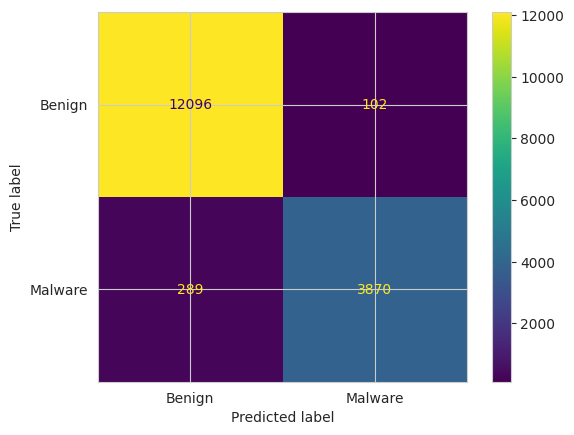

In [21]:
et_probs = et.predict_proba(X_test_ember_id)[:,1]
et_preds = et.predict(X_test_ember_id)

print("Extra Trees ROC-AUC:", roc_auc_score(y_test_ember_id, et_probs))
print(classification_report(y_test_ember_id, et_preds, target_names=['Benign', 'Malware']))

RocCurveDisplay.from_estimator(et, X_test_ember_id, y_test_ember_id)
plt.show()

ConfusionMatrixDisplay.from_estimator(et, X_test_ember_id, y_test_ember_id, display_labels=['Benign', 'Malware'])
plt.show()


In [22]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs', n_jobs=-1)
lr.fit(X_train_ember_id, y_train_ember_id)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)

Logistic Regression ROC-AUC: 0.7404047648361622
              precision    recall  f1-score   support

      Benign       0.86      0.52      0.65     12198
     Malware       0.35      0.74      0.47      4159

    accuracy                           0.58     16357
   macro avg       0.60      0.63      0.56     16357
weighted avg       0.73      0.58      0.61     16357



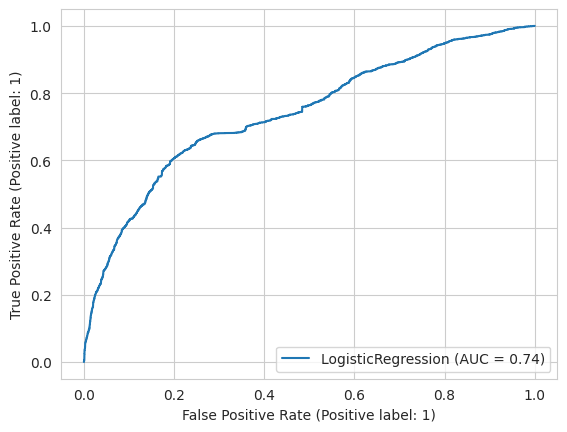

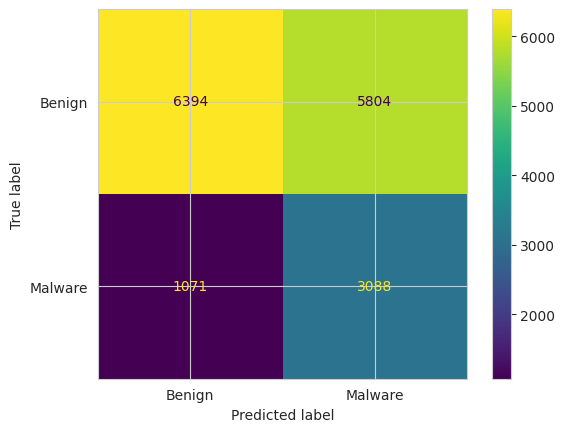

In [23]:
lr_probs = lr.predict_proba(X_test_ember_id)[:,1]
lr_preds = lr.predict(X_test_ember_id)

print("Logistic Regression ROC-AUC:", roc_auc_score(y_test_ember_id, lr_probs))
print(classification_report(y_test_ember_id, lr_preds, target_names=['Benign', 'Malware']))

RocCurveDisplay.from_estimator(lr, X_test_ember_id, y_test_ember_id)
plt.show()

ConfusionMatrixDisplay.from_estimator(lr, X_test_ember_id, y_test_ember_id, display_labels=['Benign', 'Malware'])
plt.show()


In [24]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier(iterations=300, learning_rate=0.05, class_weights=[1, scale_pos_weight_value], eval_metric='AUC', random_seed=42, verbose=100)
cb.fit(X_train_ember_id, y_train_ember_id, eval_set=(X_test_ember_id, y_test_ember_id), early_stopping_rounds=30)


0:	test: 0.9237892	best: 0.9237892 (0)	total: 221ms	remaining: 1m 6s
100:	test: 0.9920145	best: 0.9920145 (100)	total: 12s	remaining: 23.6s
200:	test: 0.9951854	best: 0.9951854 (200)	total: 24.3s	remaining: 12s
299:	test: 0.9966231	best: 0.9966231 (299)	total: 36.2s	remaining: 0us

bestTest = 0.9966230634
bestIteration = 299



CatBoost ROC-AUC: 0.99662306336724
              precision    recall  f1-score   support

      Benign       0.99      0.97      0.98     12198
     Malware       0.92      0.98      0.95      4159

    accuracy                           0.97     16357
   macro avg       0.96      0.97      0.96     16357
weighted avg       0.97      0.97      0.97     16357



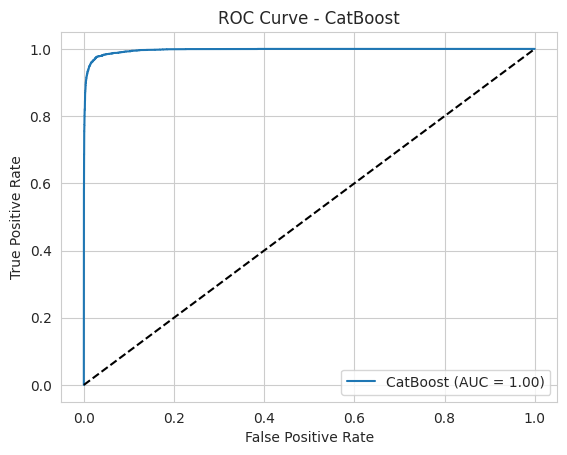

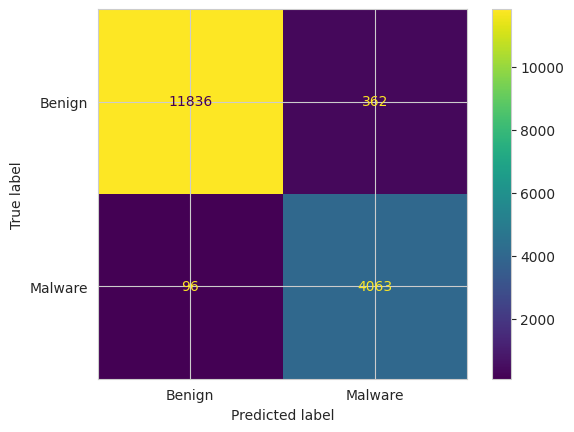

In [25]:
cb_probs = cb.predict_proba(X_test_ember_id)[:,1]
cb_preds = cb.predict(X_test_ember_id)

print("CatBoost ROC-AUC:", roc_auc_score(y_test_ember_id, cb_probs))
print(classification_report(y_test_ember_id, cb_preds, target_names=['Benign', 'Malware']))

# For ROC/Confusion Matrix, convert cb to scikit-learn wrapper or plot manually
from sklearn.metrics import roc_curve, auc, confusion_matrix

fpr, tpr, _ = roc_curve(y_test_ember_id, cb_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'CatBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost')
plt.legend()
plt.show()

cm = confusion_matrix(y_test_ember_id, cb_preds)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malware']).plot()
plt.show()

In [26]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=20, random_state=42, verbose=True)
mlp.fit(X_train_ember_id, y_train_ember_id)


Iteration 1, loss = 5.79014063
Iteration 2, loss = 5.74010381
Iteration 3, loss = 5.65453917
Iteration 4, loss = 5.59919712
Iteration 5, loss = 5.63419322
Iteration 6, loss = 5.38636806
Iteration 7, loss = 5.42231362
Iteration 8, loss = 5.29327587
Iteration 9, loss = 5.19764594
Iteration 10, loss = 5.22801780
Iteration 11, loss = 5.05829453
Iteration 12, loss = 5.02570948
Iteration 13, loss = 4.96451901
Iteration 14, loss = 5.01326810
Iteration 15, loss = 5.01114023
Iteration 16, loss = 5.01869668
Iteration 17, loss = 5.02747049
Iteration 18, loss = 4.96465402
Iteration 19, loss = 4.95530511
Iteration 20, loss = 4.98082036


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=20, random_state=42,
              verbose=True)

MLP ROC-AUC: 0.5592159913641002
              precision    recall  f1-score   support

      Benign       0.91      0.16      0.28     12198
     Malware       0.28      0.95      0.43      4159

    accuracy                           0.36     16357
   macro avg       0.60      0.56      0.36     16357
weighted avg       0.75      0.36      0.32     16357



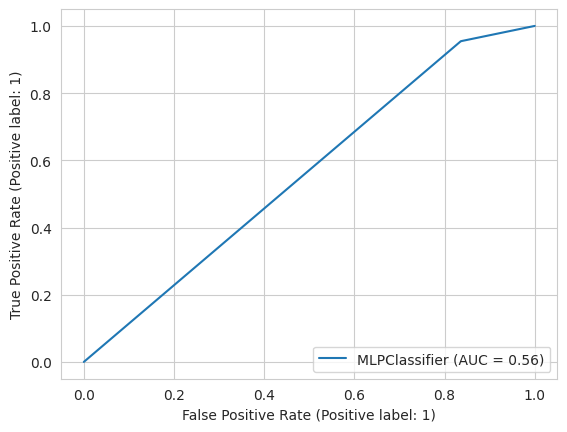

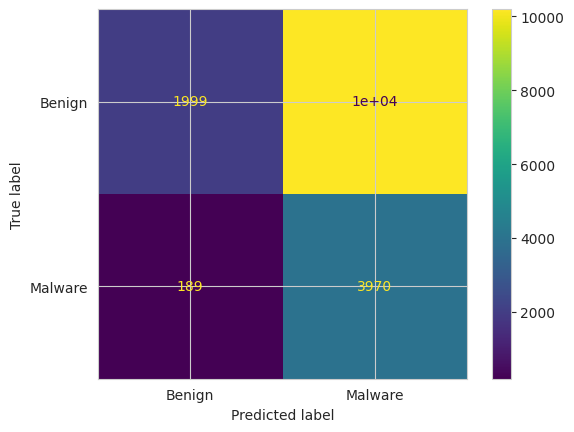

In [27]:
mlp_probs = mlp.predict_proba(X_test_ember_id)[:,1]
mlp_preds = mlp.predict(X_test_ember_id)

print("MLP ROC-AUC:", roc_auc_score(y_test_ember_id, mlp_probs))
print(classification_report(y_test_ember_id, mlp_preds, target_names=['Benign', 'Malware']))

RocCurveDisplay.from_estimator(mlp, X_test_ember_id, y_test_ember_id)
plt.show()

ConfusionMatrixDisplay.from_estimator(mlp, X_test_ember_id, y_test_ember_id, display_labels=['Benign', 'Malware'])
plt.show()


In [28]:
lgb_probs = model_ember_id.predict(X_test_ember_id, num_iteration=model_ember_id.best_iteration)
lgb_preds = (lgb_probs > 0.5).astype(int)
lgb_probs_test = model_ember_id.predict(X_test_filtered, num_iteration=model_ember_id.best_iteration)
lgb_preds_test = (lgb_probs_test > 0.5).astype(int)


LightGBM ROC-AUC: 0.9988
Accuracy: 0.9882
Precision (Malware): 0.9774
Recall (Malware): 0.9762
F1-Score (Malware): 0.9768

Classification Report:
               precision    recall  f1-score   support

      Benign       0.99      0.99      0.99     12198
     Malware       0.98      0.98      0.98      4159

    accuracy                           0.99     16357
   macro avg       0.98      0.98      0.98     16357
weighted avg       0.99      0.99      0.99     16357



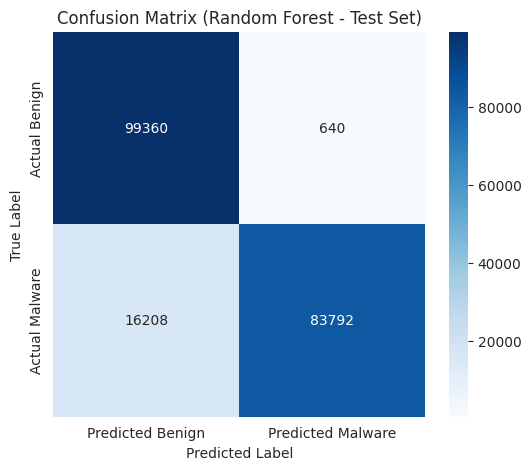

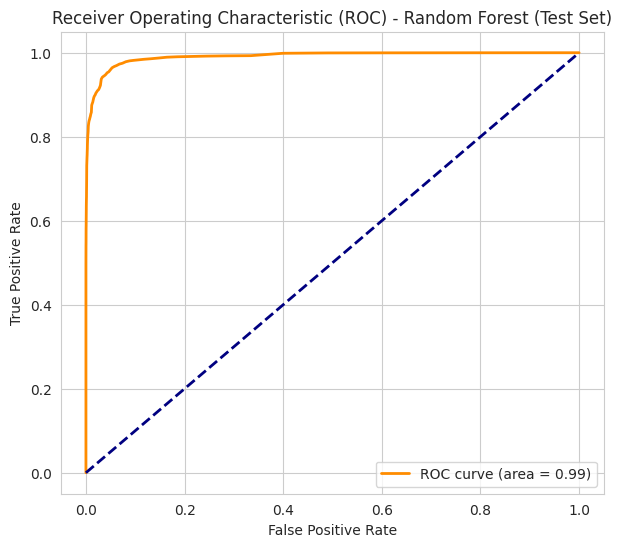

In [29]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

# Predicted probabilities and class labels
lgb_probs = model_ember_id.predict(X_test_ember_id, num_iteration=model_ember_id.best_iteration)
lgb_preds = (lgb_probs > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test_ember_id, lgb_preds)
# Precision (malware class as positive, use pos_label=1)
precision = precision_score(y_test_ember_id, lgb_preds, pos_label=1)
# Recall (malware class as positive)
recall = recall_score(y_test_ember_id, lgb_preds, pos_label=1)
# F1-Score (malware class as positive)
f1 = f1_score(y_test_ember_id, lgb_preds, pos_label=1)
# ROC-AUC Score
roc_auc = roc_auc_score(y_test_ember_id, lgb_probs)

print(f"LightGBM ROC-AUC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Malware): {precision:.4f}")
print(f"Recall (Malware): {recall:.4f}")
print(f"F1-Score (Malware): {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test_ember_id, lgb_preds, target_names=['Benign', 'Malware']))
# Make predictions with your trained Random Forest model on the dedicated test set
rf_preds_test = rf.predict(X_test_filtered)
rf_probs_test = rf.predict_proba(X_test_filtered)[:, 1]  # Probability for malware class

# Now you can plot the confusion matrix
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_true_test, rf_preds_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Benign', 'Predicted Malware'],
            yticklabels=['Actual Benign', 'Actual Malware'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Random Forest - Test Set)')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true_test, rf_probs_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Random Forest (Test Set)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


--- Starting XGBoost Classifier Training with Learning Curve Tracking ---
Calculated scale_pos_weight for XGBoost (from training set): 2.93


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(



XGBoost Model Training Time: 219.30 seconds

--- Plotting XGBoost Learning Curves ---


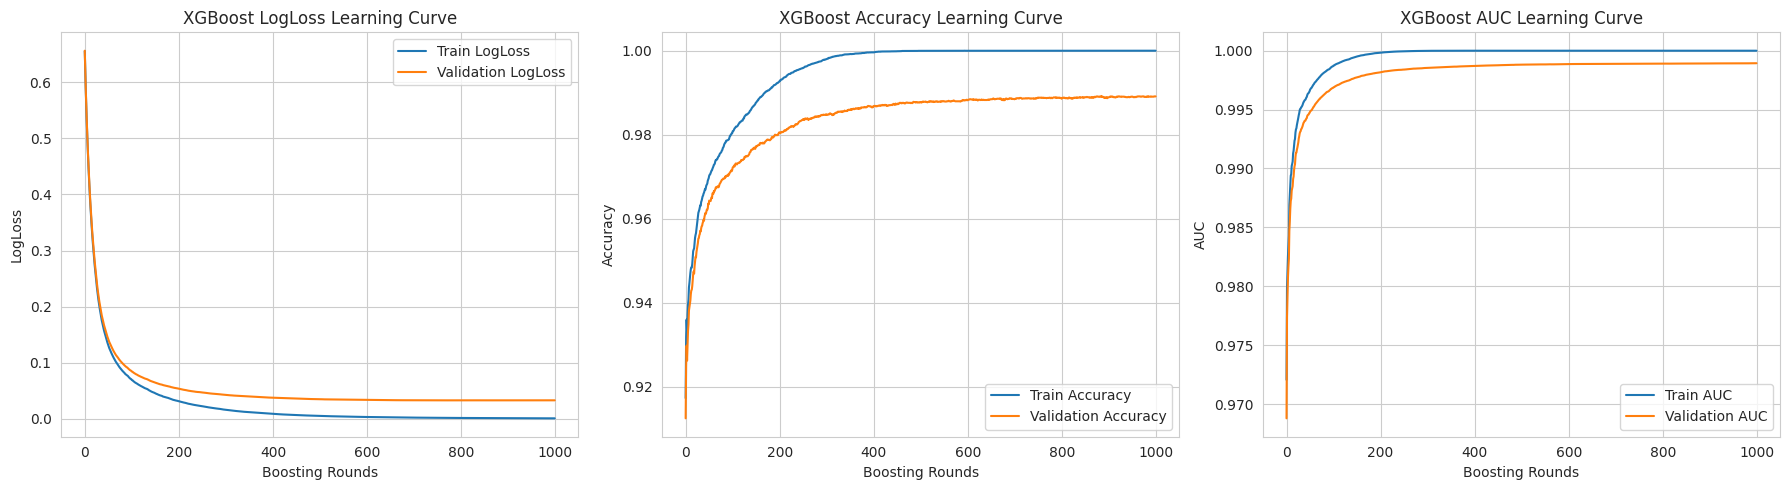


--- XGBoost Performance on Validation Set ---
Accuracy (Validation): 0.9891
ROC AUC (Validation): 0.9989

Classification Report (Validation):
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99     12198
     Malware       0.98      0.98      0.98      4159

    accuracy                           0.99     16357
   macro avg       0.99      0.99      0.99     16357
weighted avg       0.99      0.99      0.99     16357


Confusion Matrix (Validation):


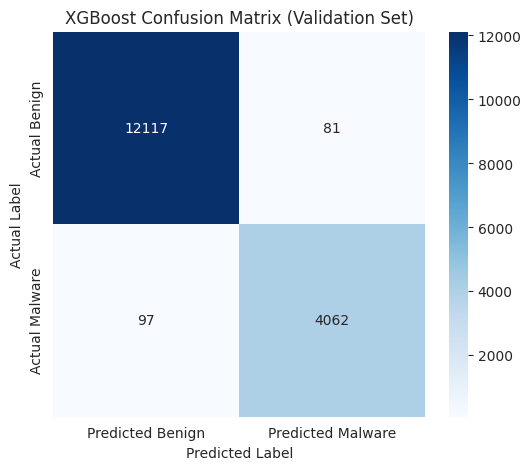


--- XGBoost Performance on Dedicated EMBER Test Set (200k samples) ---
Accuracy (Test Set): 0.9557
ROC AUC (Test Set): 0.9941

Classification Report (Test Set):
              precision    recall  f1-score   support

      Benign       0.93      0.98      0.96    100000
     Malware       0.98      0.93      0.95    100000

    accuracy                           0.96    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.96      0.96      0.96    200000


Confusion Matrix (Test Set):


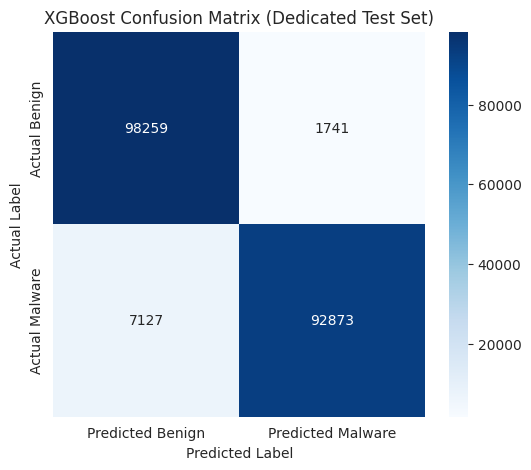


XGBoost Training and Evaluation Complete.


In [30]:
# Import necessary libraries (ensure all are imported if you restart kernel)
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import pandas as pd
import gc

print("--- Starting XGBoost Classifier Training with Learning Curve Tracking ---")

# Calculate scale_pos_weight for XGBoost based on your training set
neg_count = np.sum(y_train_ember_id == 0)
pos_count = np.sum(y_train_ember_id == 1)
scale_pos_weight_xgboost = neg_count / pos_count
print(f"Calculated scale_pos_weight for XGBoost (from training set): {scale_pos_weight_xgboost:.2f}")

# Initialize XGBoost Classifier
# Modified: eval_metric now includes 'logloss' and 'error'
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric=['logloss', 'error', 'auc'], # Track loss, error (1-accuracy), and AUC
    use_label_encoder=False,
    enable_categorical=False,
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=0.1,
    n_jobs=-1,
    random_state=42,
    scale_pos_weight=scale_pos_weight_xgboost,
    tree_method='hist',
)

# Set up early stopping (still monitors AUC)
eval_set = [(X_train_ember_id, y_train_ember_id), (X_test_ember_id, y_test_ember_id)]
callbacks = [xgb.callback.EarlyStopping(rounds=50, metric_name='auc', data_name='validation_1', save_best=True)]

start_time = time.time()
xgb_model.fit(X_train_ember_id, y_train_ember_id,
              eval_set=eval_set,
              callbacks=callbacks,
              verbose=False)

training_time_xgb = time.time() - start_time
print(f"\nXGBoost Model Training Time: {training_time_xgb:.2f} seconds")


# --- Plotting Learning Curves (Loss, Accuracy, AUC) ---
print("\n--- Plotting XGBoost Learning Curves ---")

# Access the evaluation results from the fitted model
evals_result = xgb_model.evals_result()

epochs = len(evals_result['validation_0']['logloss']) # Number of boosting rounds

plt.figure(figsize=(18, 5))

# Plot LogLoss
plt.subplot(1, 3, 1)
plt.plot(range(epochs), evals_result['validation_0']['logloss'], label='Train LogLoss')
plt.plot(range(epochs), evals_result['validation_1']['logloss'], label='Validation LogLoss')
plt.title('XGBoost LogLoss Learning Curve')
plt.xlabel('Boosting Rounds')
plt.ylabel('LogLoss')
plt.legend()
plt.grid(True)

# Plot Accuracy (from error metric)
plt.subplot(1, 3, 2)
plt.plot(range(epochs), [1 - x for x in evals_result['validation_0']['error']], label='Train Accuracy')
plt.plot(range(epochs), [1 - x for x in evals_result['validation_1']['error']], label='Validation Accuracy')
plt.title('XGBoost Accuracy Learning Curve')
plt.xlabel('Boosting Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot AUC
plt.subplot(1, 3, 3)
plt.plot(range(epochs), evals_result['validation_0']['auc'], label='Train AUC')
plt.plot(range(epochs), evals_result['validation_1']['auc'], label='Validation AUC')
plt.title('XGBoost AUC Learning Curve')
plt.xlabel('Boosting Rounds')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# --- Continue with Evaluation on Validation and Test Set (as before) ---
print("\n--- XGBoost Performance on Validation Set ---")
y_pred_proba_val_xgb = xgb_model.predict_proba(X_test_ember_id)[:, 1]
y_pred_val_xgb = (y_pred_proba_val_xgb > 0.5).astype(int)

accuracy_val_xgb = accuracy_score(y_test_ember_id, y_pred_val_xgb)
roc_auc_val_xgb = roc_auc_score(y_test_ember_id, y_pred_proba_val_xgb)

print(f"Accuracy (Validation): {accuracy_val_xgb:.4f}")
print(f"ROC AUC (Validation): {roc_auc_val_xgb:.4f}")
print("\nClassification Report (Validation):")
print(classification_report(y_test_ember_id, y_pred_val_xgb, target_names=['Benign', 'Malware'], zero_division=0))

print("\nConfusion Matrix (Validation):")
cm_val_xgb = confusion_matrix(y_test_ember_id, y_pred_val_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_val_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Benign', 'Predicted Malware'],
            yticklabels=['Actual Benign', 'Actual Malware'])
plt.title('XGBoost Confusion Matrix (Validation Set)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


print("\n--- XGBoost Performance on Dedicated EMBER Test Set (200k samples) ---")
# Ensure X_test_filtered and y_true_test are loaded from your dedicated test set (Chunk 4)

y_pred_proba_test_xgb = xgb_model.predict_proba(X_test_filtered)[:, 1]
y_pred_test_xgb = (y_pred_proba_test_xgb > 0.5).astype(int)

accuracy_test_xgb = accuracy_score(y_true_test, y_pred_test_xgb)
roc_auc_test_xgb = roc_auc_score(y_true_test, y_pred_proba_test_xgb)

print(f"Accuracy (Test Set): {accuracy_test_xgb:.4f}")
print(f"ROC AUC (Test Set): {roc_auc_test_xgb:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_true_test, y_pred_test_xgb, target_names=['Benign', 'Malware'], zero_division=0))

print("\nConfusion Matrix (Test Set):")
cm_test_xgb = confusion_matrix(y_true_test, y_pred_test_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Benign', 'Predicted Malware'],
            yticklabels=['Actual Benign', 'Actual Malware'])
plt.title('XGBoost Confusion Matrix (Dedicated Test Set)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Store XGBoost results for comparison
xgb_results = {
    'Algorithm': 'XGBoost',
    'Training Time (s)': training_time_xgb,
    'Validation Accuracy': accuracy_val_xgb,
    'Validation ROC AUC': roc_auc_val_xgb,
    'Test Accuracy': accuracy_test_xgb,
    'Test ROC AUC': roc_auc_test_xgb,
    'Test Malware Recall': cm_test_xgb[1, 1] / (cm_test_xgb[1, 0] + cm_test_xgb[1, 1]),
    'Test Benign Recall': cm_test_xgb[0, 0] / (cm_test_xgb[0, 0] + cm_test_xgb[0, 1])
}

print("\nXGBoost Training and Evaluation Complete.")


In [31]:
# Create predicted probabilities and class labels for XGBoost
xgb_probs = xgb_model.predict_proba(X_test_ember_id)[:, 1]
xgb_preds = xgb_model.predict(X_test_ember_id)


In [32]:
lgb_probs = model_ember_id.predict(X_test_ember_id, num_iteration=model_ember_id.best_iteration)
lgb_preds = (lgb_probs > 0.5).astype(int)

rf_probs = rf.predict_proba(X_test_ember_id)[:, 1]
rf_preds = rf.predict(X_test_ember_id)

et_probs = et.predict_proba(X_test_ember_id)[:, 1]
et_preds = et.predict(X_test_ember_id)

cb_probs = cb.predict_proba(X_test_ember_id)[:, 1]
cb_preds = cb.predict(X_test_ember_id)

lr_probs = lr.predict_proba(X_test_ember_id)[:, 1]
lr_preds = lr.predict(X_test_ember_id)

mlp_probs = mlp.predict_proba(X_test_ember_id)[:, 1]
mlp_preds = mlp.predict(X_test_ember_id)


In [33]:
import pandas as pd

# Data as a list of dictionaries, or directly as a DataFrame
data = {
    "Model": ["LightGBM", "XGBoost", "RandomForest", "ExtraTrees", "CatBoost", "LogReg", "MLP"],
    "Accuracy": [0.9882, 0.9891, 0.9769, 0.9761, 0.972, 0.5797, 0.8005],
    "ROC-AUC": [0.9988, 0.9989, 0.9963, 0.9961, 0.9966, 0.7404, 0.6393],
    "Precision (Malware)": [0.9774, 0.9804, 0.9751, 0.9743, 0.9182, 0.3473, 0.7651],
    "Recall (Malware)": [0.9762, 0.9767, 0.9329, 0.9305, 0.9769, 0.7425, 0.3109],
    "F1-score (Malware)": [0.9768, 0.9786, 0.9536, 0.9519, 0.9466, 0.4732, 0.4421],
}

df = pd.DataFrame(data)
print(df)


          Model  Accuracy  ROC-AUC  Precision (Malware)  Recall (Malware)  \
0      LightGBM    0.9882   0.9988               0.9774            0.9762   
1       XGBoost    0.9891   0.9989               0.9804            0.9767   
2  RandomForest    0.9769   0.9963               0.9751            0.9329   
3    ExtraTrees    0.9761   0.9961               0.9743            0.9305   
4      CatBoost    0.9720   0.9966               0.9182            0.9769   
5        LogReg    0.5797   0.7404               0.3473            0.7425   
6           MLP    0.8005   0.6393               0.7651            0.3109   

   F1-score (Malware)  
0              0.9768  
1              0.9786  
2              0.9536  
3              0.9519  
4              0.9466  
5              0.4732  
6              0.4421  


/tmp/ipykernel_36/1507953302.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[idx].set_xticklabels(models, rotation=90)


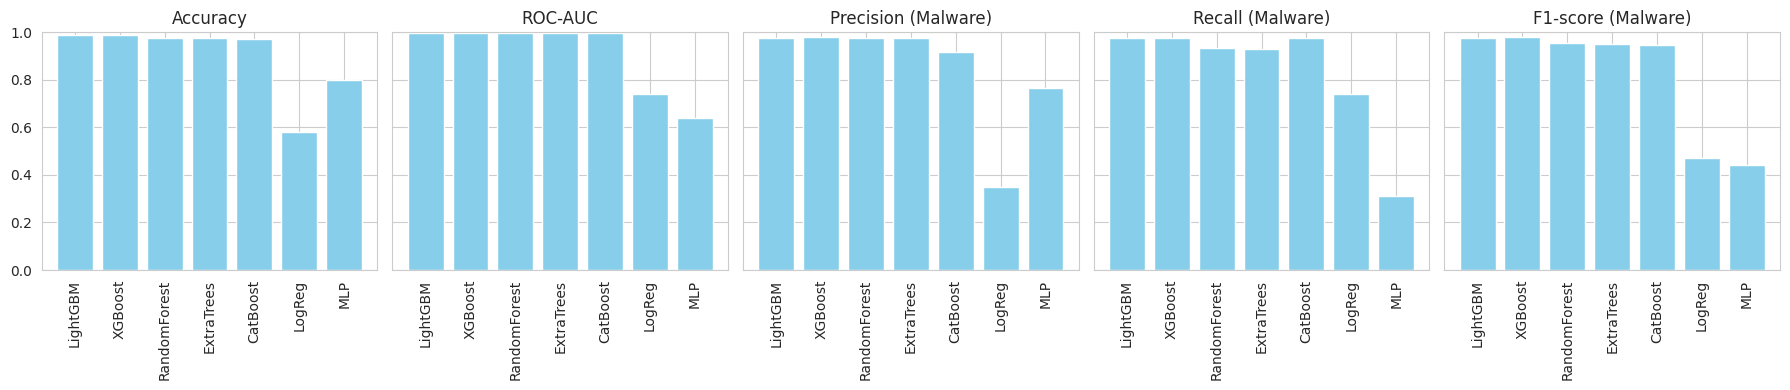

In [34]:
import matplotlib.pyplot as plt
import numpy as np

models = data['Model']
metrics = ['Accuracy', 'ROC-AUC', 'Precision (Malware)', 'Recall (Malware)', 'F1-score (Malware)']

fig, axes = plt.subplots(1, len(metrics), figsize=(18, 4), sharey=True)
for idx, metric in enumerate(metrics):
    axes[idx].bar(models, data[metric], color='skyblue')
    axes[idx].set_title(metric)
    axes[idx].set_xticklabels(models, rotation=90)
    axes[idx].set_ylim([0, 1])
plt.tight_layout()
plt.show()


In [35]:
import numpy as np
from lightgbm import LGBMClassifier

num_neg = np.sum(y_train_ember_id == 0)
num_pos = np.sum(y_train_ember_id == 1)
scale_pos_weight_value = num_neg / num_pos
print(scale_pos_weight_value)

2.9333293254779367


In [36]:
lgbm = LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    num_leaves=31,
    learning_rate=0.05,
    feature_fraction=0.9,
    n_estimators=1000,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight_value
)
lgbm.fit(X_train_ember_id, y_train_ember_id)

LGBMClassifier(feature_fraction=0.9, learning_rate=0.05, n_estimators=1000,
               n_jobs=-1, objective='binary', random_state=42,
               scale_pos_weight=2.9333293254779367)

LightGBM (LGBMClassifier) Dedicated Test Set Metrics:
  Accuracy:  0.9559
  ROC-AUC:   0.9941
  Precision (Malware): 0.9803
  Recall (Malware):    0.9304
  F1-score (Malware):  0.9547

Classification Report (Test Set):
              precision    recall  f1-score   support

      Benign       0.93      0.98      0.96    100000
     Malware       0.98      0.93      0.95    100000

    accuracy                           0.96    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.96      0.96      0.96    200000


Confusion Matrix:
[[98133  1867]
 [ 6955 93045]]


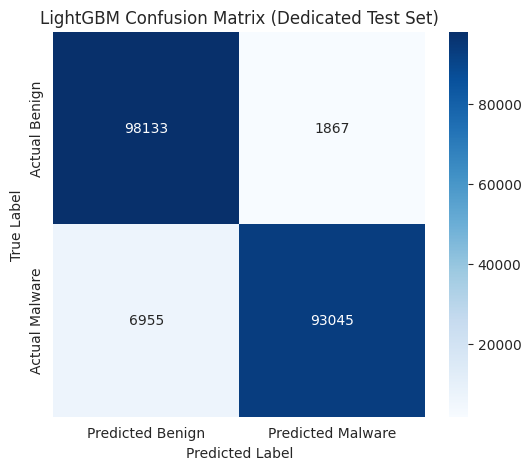

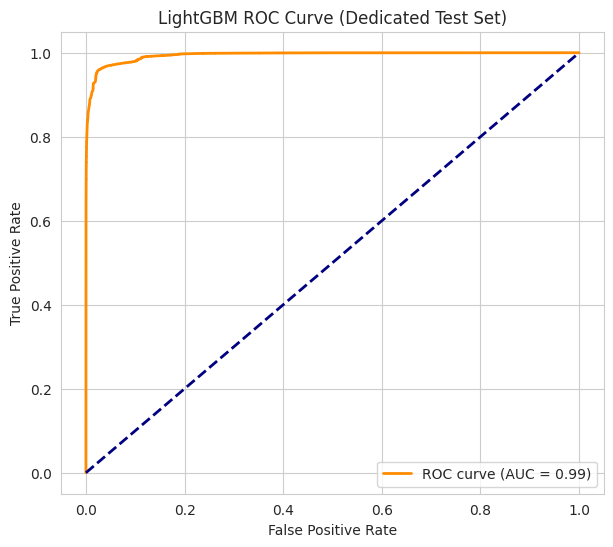

In [37]:
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions on the dedicated test set
lgbm_probs_test = lgbm.predict_proba(X_test_filtered)[:, 1]
lgbm_preds_test = lgbm.predict(X_test_filtered)

# Calculate metrics
accuracy = accuracy_score(y_true_test, lgbm_preds_test)
roc_auc = roc_auc_score(y_true_test, lgbm_probs_test)
precision = precision_score(y_true_test, lgbm_preds_test, pos_label=1)
recall = recall_score(y_true_test, lgbm_preds_test, pos_label=1)
f1 = f1_score(y_true_test, lgbm_preds_test, pos_label=1)

print(f"LightGBM (LGBMClassifier) Dedicated Test Set Metrics:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  ROC-AUC:   {roc_auc:.4f}")
print(f"  Precision (Malware): {precision:.4f}")
print(f"  Recall (Malware):    {recall:.4f}")
print(f"  F1-score (Malware):  {f1:.4f}")

# Classification report
print("\nClassification Report (Test Set):")
print(classification_report(y_true_test, lgbm_preds_test, target_names=['Benign', 'Malware']))

# Confusion Matrix
cm = confusion_matrix(y_true_test, lgbm_preds_test)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Benign', 'Predicted Malware'],
            yticklabels=['Actual Benign', 'Actual Malware'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('LightGBM Confusion Matrix (Dedicated Test Set)')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true_test, lgbm_probs_test)
roc_auc_val = auc(fpr, tpr)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM ROC Curve (Dedicated Test Set)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [38]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

# VOTING ENSEMBLE (Soft Voting)
voting_clf = VotingClassifier(
    estimators=[
        ('lgbm', lgbm),            # LightGBM (scikit-learn API)
        ('xgb', xgb_model),        # XGBoostClassifier
        ('rf', rf),                # RandomForestClassifier
        ('et', et),                # ExtraTreesClassifier
        ('cb', cb),                # CatBoostClassifier
    ],
    voting='soft',                 # Uses predicted probabilities
    n_jobs=-1
)
voting_clf.fit(X_train_ember_id, y_train_ember_id)

# Predictions and metrics for Voting Ensemble
voting_probs = voting_clf.predict_proba(X_test_ember_id)[:, 1]
voting_preds = voting_clf.predict(X_test_ember_id)

# STACKING ENSEMBLE
stacking_clf = StackingClassifier(
    estimators=[
        ('lgbm', lgbm),
        ('xgb', xgb_model),
        ('rf', rf),
        ('et', et),
        ('cb', cb)
    ],
    final_estimator=LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ),
    n_jobs=-1,
    passthrough=False
)
stacking_clf.fit(X_train_ember_id, y_train_ember_id)

# Predictions and metrics for Stacking Ensemble
stacking_probs = stacking_clf.predict_proba(X_test_ember_id)[:, 1]
stacking_preds = stacking_clf.predict(X_test_ember_id)

# EVALUATION BLOCK (for both ensembles)
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

def ensemble_results(name, y_true, y_pred, y_prob):
    print(f"\n{name} Ensemble Metrics:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_true, y_prob):.4f}")
    print(f"Precision (Malware): {precision_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"Recall (Malware): {recall_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"F1-score (Malware): {f1_score(y_true, y_pred, pos_label=1):.4f}")

ensemble_results("Voting", y_test_ember_id, voting_preds, voting_probs)
ensemble_results("Stacking", y_test_ember_id, stacking_preds, stacking_probs)


0:	total: 642ms	remaining: 3m 11s
100:	total: 42.5s	remaining: 1m 23s
200:	total: 1m 10s	remaining: 34.7s
299:	total: 1m 37s	remaining: 0us
0:	total: 647ms	remaining: 3m 13s
100:	total: 43s	remaining: 1m 24s
200:	total: 1m 9s	remaining: 34.5s
299:	total: 1m 36s	remaining: 0us
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 13308, number of negative: 39034
[LightGBM] [Warning] feature_fra

Voting Ensemble (Dedicated Test Set)
  Accuracy:           0.9560
  ROC-AUC:            0.9946
  Precision (Malware):0.9845
  Recall (Malware):   0.9265
  F1-score (Malware): 0.9546

Classification Report:
              precision    recall  f1-score   support

      Benign       0.93      0.99      0.96    100000
     Malware       0.98      0.93      0.95    100000

    accuracy                           0.96    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.96      0.96      0.96    200000



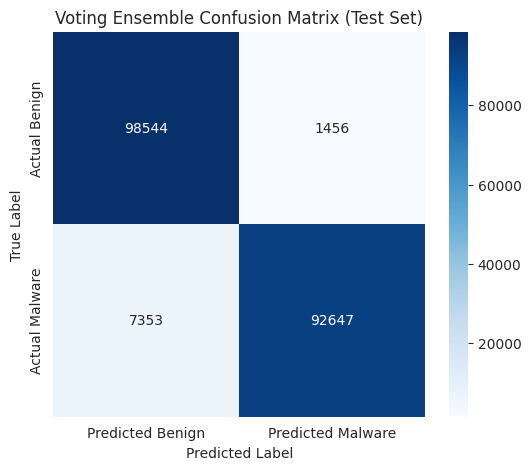

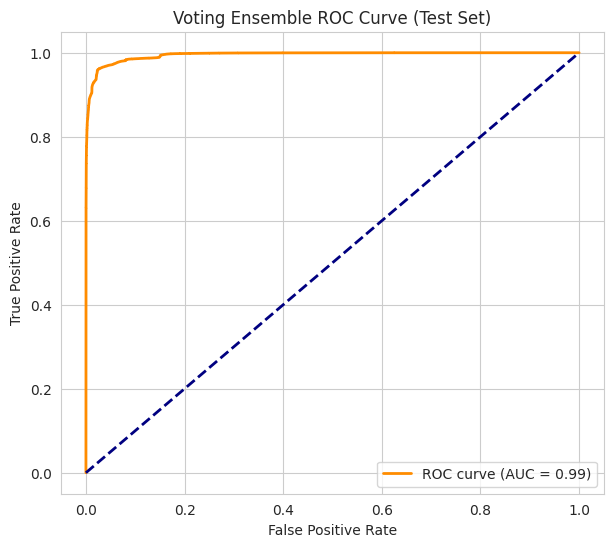

In [40]:
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions and probabilities
voting_probs_test = voting_clf.predict_proba(X_test_filtered)[:, 1]
voting_preds_test = voting_clf.predict(X_test_filtered)

# Compute metrics
accuracy = accuracy_score(y_true_test, voting_preds_test)
roc_auc = roc_auc_score(y_true_test, voting_probs_test)
precision = precision_score(y_true_test, voting_preds_test, pos_label=1)
recall = recall_score(y_true_test, voting_preds_test, pos_label=1)
f1 = f1_score(y_true_test, voting_preds_test, pos_label=1)

print("Voting Ensemble (Dedicated Test Set)")
print(f"  Accuracy:           {accuracy:.4f}")
print(f"  ROC-AUC:            {roc_auc:.4f}")
print(f"  Precision (Malware):{precision:.4f}")
print(f"  Recall (Malware):   {recall:.4f}")
print(f"  F1-score (Malware): {f1:.4f}\n")
print("Classification Report:")
print(classification_report(y_true_test, voting_preds_test, target_names=["Benign", "Malware"]))

# Confusion matrix
cm = confusion_matrix(y_true_test, voting_preds_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Benign', 'Predicted Malware'],
            yticklabels=['Actual Benign', 'Actual Malware'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Voting Ensemble Confusion Matrix (Test Set)')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true_test, voting_probs_test)
roc_auc_val = auc(fpr, tpr)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Voting Ensemble ROC Curve (Test Set)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Stacking Ensemble (Dedicated Test Set)
  Accuracy:           0.9673
  ROC-AUC:            0.9946
  Precision (Malware):0.9779
  Recall (Malware):   0.9561
  F1-score (Malware): 0.9669

Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.98      0.97    100000
     Malware       0.98      0.96      0.97    100000

    accuracy                           0.97    200000
   macro avg       0.97      0.97      0.97    200000
weighted avg       0.97      0.97      0.97    200000



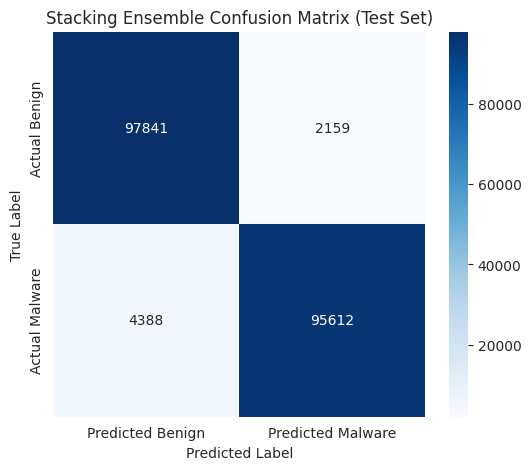

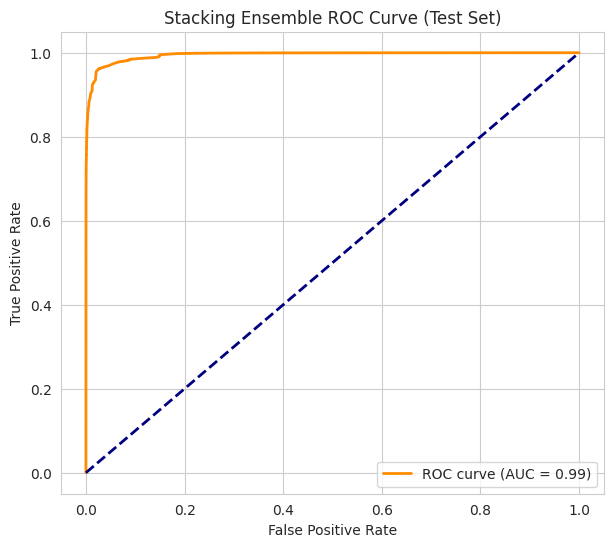

In [41]:
# Generate predictions and probabilities
stacking_probs_test = stacking_clf.predict_proba(X_test_filtered)[:, 1]
stacking_preds_test = stacking_clf.predict(X_test_filtered)

# Compute metrics
accuracy = accuracy_score(y_true_test, stacking_preds_test)
roc_auc = roc_auc_score(y_true_test, stacking_probs_test)
precision = precision_score(y_true_test, stacking_preds_test, pos_label=1)
recall = recall_score(y_true_test, stacking_preds_test, pos_label=1)
f1 = f1_score(y_true_test, stacking_preds_test, pos_label=1)

print("Stacking Ensemble (Dedicated Test Set)")
print(f"  Accuracy:           {accuracy:.4f}")
print(f"  ROC-AUC:            {roc_auc:.4f}")
print(f"  Precision (Malware):{precision:.4f}")
print(f"  Recall (Malware):   {recall:.4f}")
print(f"  F1-score (Malware): {f1:.4f}\n")
print("Classification Report:")
print(classification_report(y_true_test, stacking_preds_test, target_names=["Benign", "Malware"]))

# Confusion matrix
cm = confusion_matrix(y_true_test, stacking_preds_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Benign', 'Predicted Malware'],
            yticklabels=['Actual Benign', 'Actual Malware'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Stacking Ensemble Confusion Matrix (Test Set)')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true_test, stacking_probs_test)
roc_auc_val = auc(fpr, tpr)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stacking Ensemble ROC Curve (Test Set)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
